In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np

import config

In [2]:
# training parameters
seed= config.seed

dr=0.8
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=5000
mini_batch_size=4

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=1

# radius or residues
feature='radius'

# if features is residues ''<coefficients>_' for example '17_' otherwhise ''
coefficients= '' if feature == 'radius' else '17_'

print_sample=False

In [3]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/{}_{}20220911.csv".format(feature, coefficients)) #TODO automate
features = features.set_index(features.columns[0]).T.sort_index()
print("Loaded data from CSV")
features.sample(5)

Loaded data from CSV


Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
T028_1,0.0,367.936634,1460.155091,1650.482081,1617.216955,1338.266265,1371.702739,1410.352829,1517.652421,2090.453754,...,5148.404246,5364.075665,5262.852070,5352.660359,5458.654547,5253.211506,5685.839579,5088.515621,5922.930829,4881.490390
C107_2,0.0,355.624075,135.638193,24.976693,113.897150,93.545709,567.438441,1798.279530,2935.076736,3349.572671,...,3991.294898,4130.069025,3912.524597,3554.376996,3528.579667,3995.376782,4479.075345,4231.423738,2977.290141,1263.206580
C107_1,0.0,209.955778,33.039293,331.467589,657.585998,2039.099791,3274.273834,3282.449534,2798.993756,2852.125314,...,2552.485869,2355.051414,2342.130728,2589.999562,2558.077090,2232.754493,2339.412103,2831.219438,2560.642223,1203.203925
T002_2,0.0,186.494217,66.291958,119.731954,94.141079,94.306414,102.259397,94.775667,108.611383,96.564239,...,1386.302150,1412.698850,1460.361797,1406.439397,1283.762619,1276.047548,1437.234302,1520.238990,1222.252945,582.119014
T023_1,0.0,229.785965,610.564039,1795.359923,3544.526478,2996.761792,3352.063018,3015.955960,2752.688953,2655.696795,...,1587.287426,1639.102876,1581.597228,1642.130744,1569.923037,1645.824056,1550.075378,1652.964912,1511.668266,1685.323466


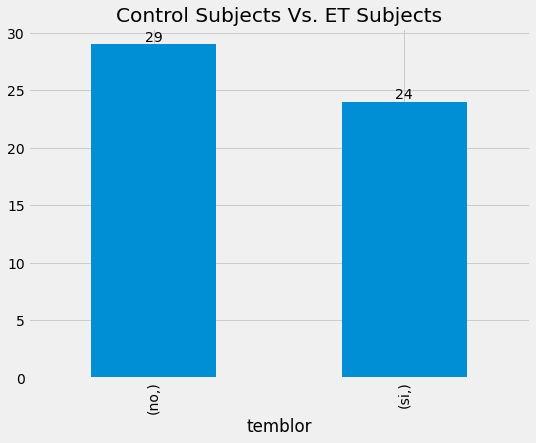

In [4]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/binary_labels_20220903.csv", index_col=0).sort_index()
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

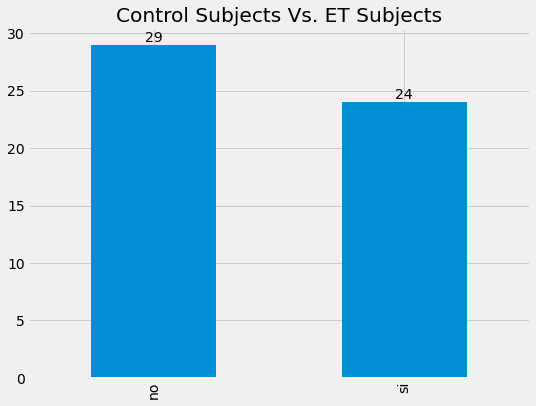

In [5]:
labels.columns = ['labels']
labels = features.join(labels).labels
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [6]:
np.array_equal(features.index.unique().values, labels.index.values)

True

In [7]:
from sklearn import preprocessing
#lb = preprocessing.LabelBinarizer()
#y = lb.fit_transform(labels).astype(np.int16)
#y.shape
#binary labels
le = LabelEncoder().fit(labels.values.ravel())
y = le.fit_transform(labels.values.ravel()).astype(np.int16)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int16)

In [8]:
X=features.values.astype(np.float64)
X.shape

(53, 4096)

In [9]:
scaler = MinMaxScaler()
print(scaler.fit(X))
print(scaler.data_max_)
#print(scaler.mean_)
print(scaler.transform(X))

MinMaxScaler()
[   0.         1371.16571794 3938.46800727 ... 6611.16220004 6777.5403416
 4997.8457149 ]
[[0.         0.07982281 0.00302512 ... 0.0584983  0.03160606 0.03526998]
 [0.         0.10822861 0.         ... 0.11494715 0.08453906 0.07072379]
 [0.         0.09888193 0.01897245 ... 0.0854721  0.0315158  0.02881741]
 ...
 [0.         0.25041419 0.37067958 ... 0.73743403 0.85719899 0.97513719]
 [0.         0.05324481 0.02075691 ... 0.07114234 0.         0.        ]
 [0.         0.14614354 0.33580221 ... 0.2049907  0.24341224 0.3384946 ]]


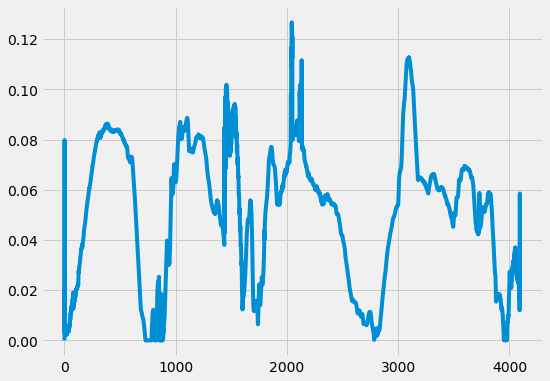

In [10]:
x_train, x_test, y_train, y_test = train_test_split(scaler.transform(X), y, test_size=0.33, random_state=seed)
plt.plot(x_train[10,:])

In [11]:
x_train.shape, x_test.shape

((35, 4096), (18, 4096))

In [12]:
#train_mean = x_train.mean()
#train_std = x_train.std()

#x_train = (x_train - train_mean) / train_std
#x_test = (x_test - train_mean) / train_std
#plt.plot(x_train[10,:])

In [13]:
num_features = x_train.shape[1]

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

9 train batches and 5 test batches of 4 mini batch size and 2 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [15]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-4),
      ]

def compile_and_fit(model, train_dataset, test_dataset, optimizer=None, max_epochs=1000, loss='categorical_crossentropy'):
    
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()
   
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [16]:
size_histories = {}

In [17]:
inputs = tf.keras.Input(shape=(num_features,))

dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/tiny/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,
#                                              optimizer=tf.keras.optimizers.Adam(lr), 
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs,
                                              loss='binary_crossentropy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


9/9 [==============================] - 1s 12ms/step - loss: 0.7333 - accuracy: 0.4571 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7136 - accuracy: 0.4857 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 3/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.6000 - val_loss: 0.6829 - val_accuracy: 0.6111
Epoch 4/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5714 - val_loss: 0.6738 - val_accuracy: 0.6667
Epoch 5/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6727 - accuracy: 0.5143 - val_loss: 0.6755 - val_accuracy: 0.7222
Epoch 6/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.6000 - val_loss: 0.6711 - val_accuracy: 0.7778
Epoch 7/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6494 - accuracy: 0.5143 - val_loss: 0.6708 - val_accuracy: 0.7222
Epoch 8/5000
9/9 [==============

9/9 [==============================] - 0s 3ms/step - loss: 0.4495 - accuracy: 0.8000 - val_loss: 0.6873 - val_accuracy: 0.5556
Epoch 60/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4470 - accuracy: 0.8000 - val_loss: 0.6885 - val_accuracy: 0.5556
Epoch 61/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.8000 - val_loss: 0.6904 - val_accuracy: 0.5556
Epoch 62/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4427 - accuracy: 0.8000 - val_loss: 0.6915 - val_accuracy: 0.5556
Epoch 63/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4407 - accuracy: 0.8000 - val_loss: 0.6922 - val_accuracy: 0.5556
Epoch 64/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4384 - accuracy: 0.8000 - val_loss: 0.6945 - val_accuracy: 0.5556
Epoch 65/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.8000 - val_loss: 0.6956 - val_accuracy: 0.5556
Epoch 66/5000
9/9 [========

9/9 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8571 - val_loss: 0.7902 - val_accuracy: 0.5556
Epoch 118/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3555 - accuracy: 0.8571 - val_loss: 0.7924 - val_accuracy: 0.5556
Epoch 119/5000
9/9 [==============================] - 0s 6ms/step - loss: 0.3544 - accuracy: 0.8571 - val_loss: 0.7940 - val_accuracy: 0.5556
Epoch 120/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3532 - accuracy: 0.8571 - val_loss: 0.7961 - val_accuracy: 0.5556
Epoch 121/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8571 - val_loss: 0.7983 - val_accuracy: 0.5556
Epoch 122/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8571 - val_loss: 0.8008 - val_accuracy: 0.5556
Epoch 123/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 0.8571 - val_loss: 0.8038 - val_accuracy: 0.5556
Epoch 124/5000
9/9 [=

Epoch 175/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8857 - val_loss: 0.9279 - val_accuracy: 0.7222
Epoch 176/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3023 - accuracy: 0.8857 - val_loss: 0.9299 - val_accuracy: 0.7222
Epoch 177/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3016 - accuracy: 0.8857 - val_loss: 0.9310 - val_accuracy: 0.7222
Epoch 178/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.8857 - val_loss: 0.9332 - val_accuracy: 0.7222
Epoch 179/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.8857 - val_loss: 0.9361 - val_accuracy: 0.7222
Epoch 180/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2994 - accuracy: 0.8857 - val_loss: 0.9391 - val_accuracy: 0.7222
Epoch 181/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2985 - accuracy: 0.8857 - val_loss: 0.9422 - val_accuracy: 0.7222
Epoch 

In [18]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.9143
training loss : 0.2675377130508423
training accuracy : 0.9142857193946838
5/5 [==============================] - 0s 1ms/step - loss: 1.0489 - accuracy: 0.6667
test loss : 1.0488600730895996
test accuracy : 0.6666666865348816


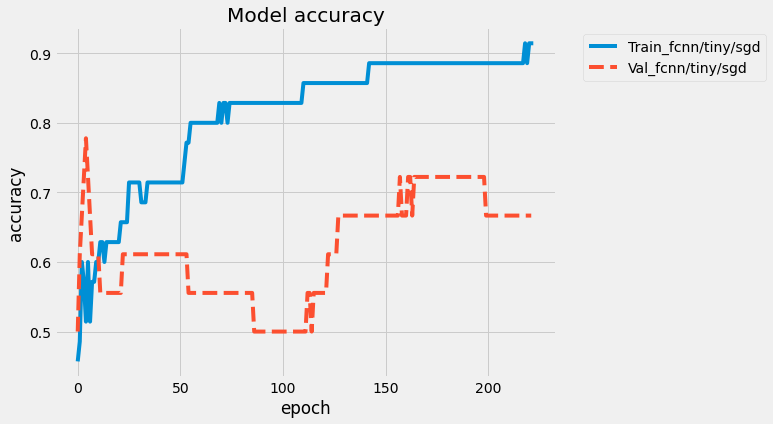

In [19]:
plot_report(size_histories, metric='accuracy')

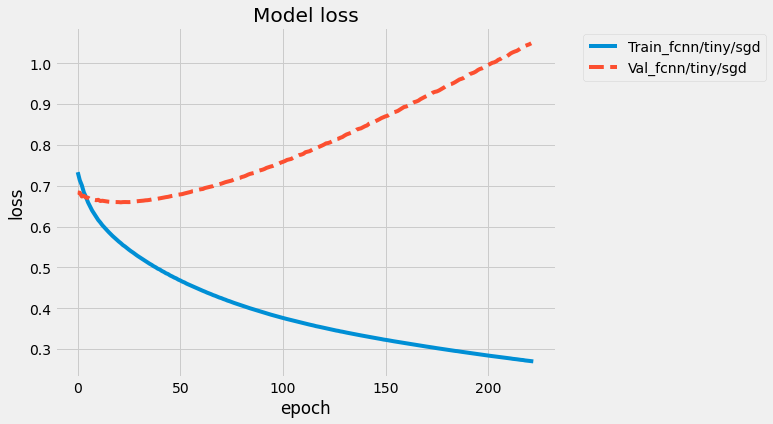

In [20]:
plot_report(size_histories, 'loss')

In [21]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dense_1)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_2)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/small/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,loss='binary_crossentropy',
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 263,265
Trainable params: 263,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
9/9 [==============================] - 0s 14ms/step - loss: 0.7037 - accuracy: 0.5429 - val_loss: 0.6845 - val_accuracy: 0.6111
Epoch 2/5000
9/9 [============================

9/9 [==============================] - 0s 3ms/step - loss: 0.4977 - accuracy: 0.7714 - val_loss: 0.6577 - val_accuracy: 0.5556
Epoch 53/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.7714 - val_loss: 0.6578 - val_accuracy: 0.5556
Epoch 54/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.7714 - val_loss: 0.6588 - val_accuracy: 0.5556
Epoch 55/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.8000 - val_loss: 0.6596 - val_accuracy: 0.5556
Epoch 56/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4826 - accuracy: 0.8286 - val_loss: 0.6607 - val_accuracy: 0.5556
Epoch 57/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4788 - accuracy: 0.8286 - val_loss: 0.6614 - val_accuracy: 0.6111
Epoch 58/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4752 - accuracy: 0.8286 - val_loss: 0.6615 - val_accuracy: 0.6111
Epoch 59/5000
9/9 [========

9/9 [==============================] - 0s 2ms/step - loss: 0.3432 - accuracy: 0.8571 - val_loss: 0.7845 - val_accuracy: 0.6111
Epoch 111/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3412 - accuracy: 0.8571 - val_loss: 0.7902 - val_accuracy: 0.6111
Epoch 112/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3403 - accuracy: 0.8571 - val_loss: 0.7917 - val_accuracy: 0.6111
Epoch 113/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3363 - accuracy: 0.8286 - val_loss: 0.7980 - val_accuracy: 0.6667
Epoch 114/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3369 - accuracy: 0.8571 - val_loss: 0.8001 - val_accuracy: 0.6111
Epoch 115/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3337 - accuracy: 0.8571 - val_loss: 0.8022 - val_accuracy: 0.6111
Epoch 116/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.8571 - val_loss: 0.8041 - val_accuracy: 0.6111
Epoch 117/5000
9/9 [=

Epoch 168/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.8857 - val_loss: 1.0322 - val_accuracy: 0.6667
Epoch 169/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2532 - accuracy: 0.8857 - val_loss: 1.0354 - val_accuracy: 0.6667
Epoch 170/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.8857 - val_loss: 1.0448 - val_accuracy: 0.6667
Epoch 171/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.8857 - val_loss: 1.0524 - val_accuracy: 0.6667
Epoch 172/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2482 - accuracy: 0.8857 - val_loss: 1.0561 - val_accuracy: 0.6667
Epoch 173/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.9143 - val_loss: 1.0637 - val_accuracy: 0.6667
Epoch 174/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.8857 - val_loss: 1.0690 - val_accuracy: 0.6667
Epoch 

Epoch 226/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1857 - accuracy: 0.9714 - val_loss: 1.3778 - val_accuracy: 0.6111
Epoch 227/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1848 - accuracy: 0.9714 - val_loss: 1.3804 - val_accuracy: 0.6111
Epoch 228/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1836 - accuracy: 0.9714 - val_loss: 1.3932 - val_accuracy: 0.6111
Epoch 229/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1829 - accuracy: 0.9714 - val_loss: 1.3972 - val_accuracy: 0.6111
Epoch 230/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9714 - val_loss: 1.3999 - val_accuracy: 0.6111
Epoch 231/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9714 - val_loss: 1.4122 - val_accuracy: 0.6111
Epoch 232/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.1802 - accuracy: 0.9714 - val_loss: 1.4135 - val_accuracy: 0.6111
Epoch 

In [22]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.1709 - accuracy: 0.9714
training loss : 0.17087647318840027
training accuracy : 0.9714285731315613
5/5 [==============================] - 0s 1ms/step - loss: 1.4570 - accuracy: 0.6667
test loss : 1.4569861888885498
test accuracy : 0.6666666865348816


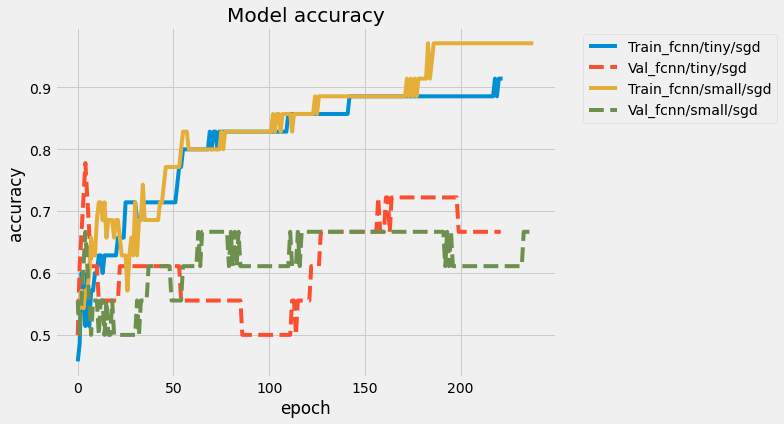

In [23]:
plot_report(size_histories)

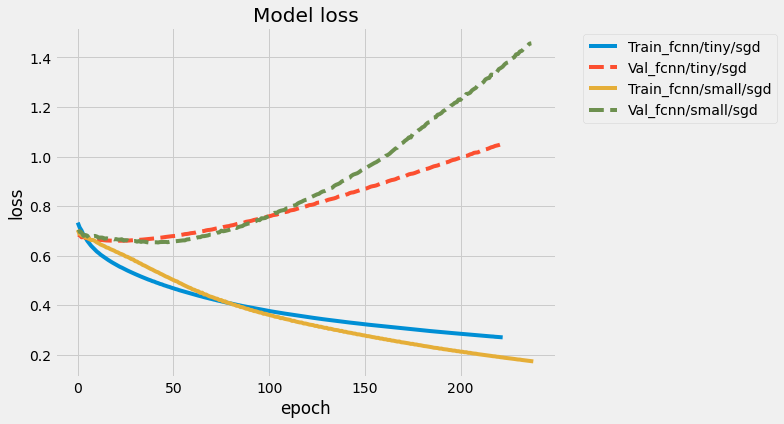

In [24]:
plot_report(size_histories, 'loss')

In [25]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dense_1)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid)(dense_2)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid)(dense_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/large/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,
                                              loss='binary_crossentropy',
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 263,665
Trainable params: 263,665
Non-trainable

9/9 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.7143 - val_accuracy: 0.3333
Epoch 51/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.7142 - val_accuracy: 0.3333
Epoch 52/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.7141 - val_accuracy: 0.3333
Epoch 53/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.7140 - val_accuracy: 0.3333
Epoch 54/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5143 - val_loss: 0.7139 - val_accuracy: 0.3333
Epoch 55/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5143 - val_loss: 0.7138 - val_accuracy: 0.3333
Epoch 56/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5143 - val_loss: 0.7138 - val_accuracy: 0.3333
Epoch 57/5000
9/9 [========

9/9 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5143 - val_loss: 0.7123 - val_accuracy: 0.3333
Epoch 109/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5143 - val_loss: 0.7123 - val_accuracy: 0.3333
Epoch 110/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5143 - val_loss: 0.7123 - val_accuracy: 0.3333
Epoch 111/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5143 - val_loss: 0.7122 - val_accuracy: 0.3333
Epoch 112/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5143 - val_loss: 0.7122 - val_accuracy: 0.3333
Epoch 113/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5143 - val_loss: 0.7122 - val_accuracy: 0.3333
Epoch 114/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5143 - val_loss: 0.7122 - val_accuracy: 0.3333
Epoch 115/5000
9/9 [=

Epoch 166/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5143 - val_loss: 0.7118 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5143 - val_loss: 0.7118 - val_accuracy: 0.3333
Epoch 168/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5143 - val_loss: 0.7118 - val_accuracy: 0.3333
Epoch 169/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5143 - val_loss: 0.7117 - val_accuracy: 0.3333
Epoch 170/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5143 - val_loss: 0.7118 - val_accuracy: 0.3333
Epoch 171/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5143 - val_loss: 0.7117 - val_accuracy: 0.3333
Epoch 172/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5143 - val_loss: 0.7117 - val_accuracy: 0.3333
Epoch 

Epoch 224/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5143 - val_loss: 0.7113 - val_accuracy: 0.3333
Epoch 225/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5143 - val_loss: 0.7113 - val_accuracy: 0.3333
Epoch 226/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5143 - val_loss: 0.7113 - val_accuracy: 0.3333
Epoch 227/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5143 - val_loss: 0.7113 - val_accuracy: 0.3333
Epoch 228/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5143 - val_loss: 0.7112 - val_accuracy: 0.3333
Epoch 229/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5143 - val_loss: 0.7112 - val_accuracy: 0.3333
Epoch 230/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5143 - val_loss: 0.7112 - val_accuracy: 0.3333
Epoch 

Epoch 282/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5143 - val_loss: 0.7106 - val_accuracy: 0.3333
Epoch 283/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5143 - val_loss: 0.7106 - val_accuracy: 0.3333
Epoch 284/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5143 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 285/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5143 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 286/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5143 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 287/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5143 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 288/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5143 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 

Epoch 340/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5143 - val_loss: 0.7097 - val_accuracy: 0.3889
Epoch 341/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5143 - val_loss: 0.7097 - val_accuracy: 0.3889
Epoch 342/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5143 - val_loss: 0.7097 - val_accuracy: 0.3889
Epoch 343/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5143 - val_loss: 0.7097 - val_accuracy: 0.3889
Epoch 344/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5143 - val_loss: 0.7096 - val_accuracy: 0.3889
Epoch 345/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5143 - val_loss: 0.7096 - val_accuracy: 0.3889
Epoch 346/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5143 - val_loss: 0.7096 - val_accuracy: 0.3889
Epoch 

Epoch 398/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5714 - val_loss: 0.7086 - val_accuracy: 0.3333
Epoch 399/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5714 - val_loss: 0.7085 - val_accuracy: 0.3333
Epoch 400/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5714 - val_loss: 0.7085 - val_accuracy: 0.3333
Epoch 401/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5714 - val_loss: 0.7084 - val_accuracy: 0.3333
Epoch 402/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6802 - accuracy: 0.5714 - val_loss: 0.7085 - val_accuracy: 0.3333
Epoch 403/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5714 - val_loss: 0.7085 - val_accuracy: 0.3333
Epoch 404/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.5714 - val_loss: 0.7084 - val_accuracy: 0.3333
Epoch 

Epoch 456/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6751 - accuracy: 0.6571 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 457/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6751 - accuracy: 0.6571 - val_loss: 0.7072 - val_accuracy: 0.5000
Epoch 458/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6749 - accuracy: 0.6571 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 459/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6748 - accuracy: 0.6571 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 460/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6571 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 461/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.6571 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 462/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.6571 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 

Epoch 514/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.6571 - val_loss: 0.7050 - val_accuracy: 0.3889
Epoch 515/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.6571 - val_loss: 0.7052 - val_accuracy: 0.3889
Epoch 516/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.6571 - val_loss: 0.7050 - val_accuracy: 0.3889
Epoch 517/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6663 - accuracy: 0.6571 - val_loss: 0.7049 - val_accuracy: 0.3889
Epoch 518/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6571 - val_loss: 0.7048 - val_accuracy: 0.3889
Epoch 519/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.6571 - val_loss: 0.7049 - val_accuracy: 0.3889
Epoch 520/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6571 - val_loss: 0.7048 - val_accuracy: 0.3889
Epoch 

Epoch 572/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6857 - val_loss: 0.7015 - val_accuracy: 0.4444
Epoch 573/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6857 - val_loss: 0.7012 - val_accuracy: 0.4444
Epoch 574/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6857 - val_loss: 0.7012 - val_accuracy: 0.4444
Epoch 575/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6857 - val_loss: 0.7011 - val_accuracy: 0.4444
Epoch 576/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6857 - val_loss: 0.7010 - val_accuracy: 0.4444
Epoch 577/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6517 - accuracy: 0.6857 - val_loss: 0.7009 - val_accuracy: 0.4444
Epoch 578/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.6857 - val_loss: 0.7008 - val_accuracy: 0.4444
Epoch 

Epoch 630/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6857 - val_loss: 0.6950 - val_accuracy: 0.4444
Epoch 631/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6857 - val_loss: 0.6950 - val_accuracy: 0.4444
Epoch 632/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6857 - val_loss: 0.6948 - val_accuracy: 0.4444
Epoch 633/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6857 - val_loss: 0.6948 - val_accuracy: 0.4444
Epoch 634/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6857 - val_loss: 0.6946 - val_accuracy: 0.4444
Epoch 635/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6857 - val_loss: 0.6944 - val_accuracy: 0.4444
Epoch 636/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6857 - val_loss: 0.6942 - val_accuracy: 0.4444
Epoch 

Epoch 688/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.5937 - accuracy: 0.7714 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 689/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.7714 - val_loss: 0.6855 - val_accuracy: 0.5000
Epoch 690/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5923 - accuracy: 0.7714 - val_loss: 0.6855 - val_accuracy: 0.5000
Epoch 691/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.7714 - val_loss: 0.6852 - val_accuracy: 0.5000
Epoch 692/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.5906 - accuracy: 0.7714 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 693/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7714 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 694/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.7714 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 

Epoch 746/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5390 - accuracy: 0.7429 - val_loss: 0.6761 - val_accuracy: 0.5556
Epoch 747/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5380 - accuracy: 0.7429 - val_loss: 0.6764 - val_accuracy: 0.5556
Epoch 748/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5367 - accuracy: 0.7429 - val_loss: 0.6756 - val_accuracy: 0.5556
Epoch 749/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5358 - accuracy: 0.7429 - val_loss: 0.6760 - val_accuracy: 0.5556
Epoch 750/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5347 - accuracy: 0.7429 - val_loss: 0.6758 - val_accuracy: 0.5556
Epoch 751/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5333 - accuracy: 0.7429 - val_loss: 0.6753 - val_accuracy: 0.5556
Epoch 752/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5325 - accuracy: 0.7429 - val_loss: 0.6755 - val_accuracy: 0.5556
Epoch 

Epoch 804/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4692 - accuracy: 0.8286 - val_loss: 0.6666 - val_accuracy: 0.5556
Epoch 805/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4684 - accuracy: 0.8571 - val_loss: 0.6671 - val_accuracy: 0.5556
Epoch 806/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.8571 - val_loss: 0.6669 - val_accuracy: 0.6111
Epoch 807/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.8571 - val_loss: 0.6664 - val_accuracy: 0.6111
Epoch 808/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4642 - accuracy: 0.8571 - val_loss: 0.6665 - val_accuracy: 0.6111
Epoch 809/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.8571 - val_loss: 0.6660 - val_accuracy: 0.6111
Epoch 810/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.4621 - accuracy: 0.8571 - val_loss: 0.6667 - val_accuracy: 0.6111
Epoch 

Epoch 862/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3950 - accuracy: 0.8857 - val_loss: 0.6801 - val_accuracy: 0.6667
Epoch 863/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3938 - accuracy: 0.8857 - val_loss: 0.6826 - val_accuracy: 0.6667
Epoch 864/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3925 - accuracy: 0.8857 - val_loss: 0.6819 - val_accuracy: 0.6667
Epoch 865/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3913 - accuracy: 0.8857 - val_loss: 0.6819 - val_accuracy: 0.6667
Epoch 866/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3899 - accuracy: 0.8857 - val_loss: 0.6838 - val_accuracy: 0.6667
Epoch 867/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3887 - accuracy: 0.8857 - val_loss: 0.6839 - val_accuracy: 0.6667
Epoch 868/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3875 - accuracy: 0.8857 - val_loss: 0.6849 - val_accuracy: 0.6667
Epoch 

Epoch 920/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3270 - accuracy: 0.8857 - val_loss: 0.7324 - val_accuracy: 0.6667
Epoch 921/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3262 - accuracy: 0.8857 - val_loss: 0.7337 - val_accuracy: 0.6667
Epoch 922/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3248 - accuracy: 0.8857 - val_loss: 0.7345 - val_accuracy: 0.6667
Epoch 923/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3238 - accuracy: 0.8857 - val_loss: 0.7359 - val_accuracy: 0.6667
Epoch 924/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3228 - accuracy: 0.8857 - val_loss: 0.7370 - val_accuracy: 0.6667
Epoch 925/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.3217 - accuracy: 0.8857 - val_loss: 0.7382 - val_accuracy: 0.6667
Epoch 926/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3204 - accuracy: 0.8857 - val_loss: 0.7384 - val_accuracy: 0.6667
Epoch 

Epoch 978/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2662 - accuracy: 0.9429 - val_loss: 0.7977 - val_accuracy: 0.6111
Epoch 979/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2651 - accuracy: 0.9429 - val_loss: 0.7988 - val_accuracy: 0.6111
Epoch 980/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.9429 - val_loss: 0.7998 - val_accuracy: 0.6111
Epoch 981/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.9429 - val_loss: 0.8009 - val_accuracy: 0.6667
Epoch 982/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2619 - accuracy: 0.9429 - val_loss: 0.8026 - val_accuracy: 0.6667
Epoch 983/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2610 - accuracy: 0.9429 - val_loss: 0.8037 - val_accuracy: 0.6667
Epoch 984/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.9429 - val_loss: 0.8043 - val_accuracy: 0.6667
Epoch 

In [26]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.2286 - accuracy: 0.9714
training loss : 0.22862042486667633
training accuracy : 0.9714285731315613
5/5 [==============================] - 0s 1ms/step - loss: 0.8398 - accuracy: 0.6667
test loss : 0.8397953510284424
test accuracy : 0.6666666865348816


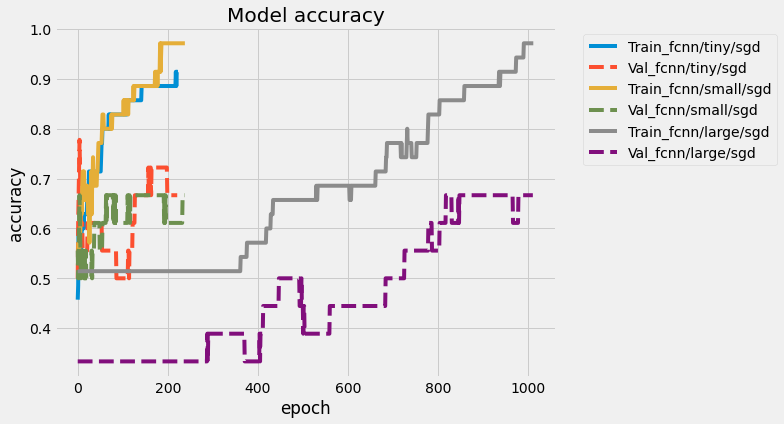

In [27]:
plot_report(size_histories)

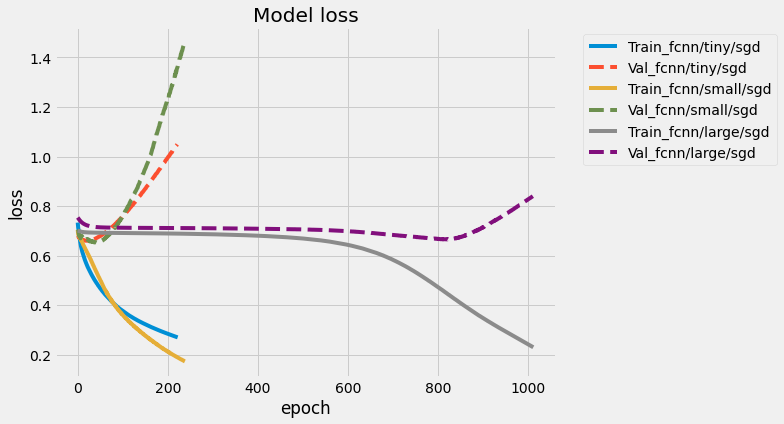

In [28]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [29]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dropout_1 = tf.keras.layers.Dropout(dr)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dr)(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid)(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dr)(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid)(dropout_3)
dropout_4 = tf.keras.layers.Dropout(dr)(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dropout_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/large/dropout/sgd'] = compile_and_fit(model, 
                                                      train_dataset,
                                                      test_dataset,
                                                      optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                      max_epochs=num_epochs,
                                                      loss='binary_crossentropy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                65552     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136   

Epoch 48/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5429 - val_loss: 0.7169 - val_accuracy: 0.3333
Epoch 49/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.5429 - val_loss: 0.7160 - val_accuracy: 0.3333
Epoch 50/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7539 - accuracy: 0.4286 - val_loss: 0.7145 - val_accuracy: 0.3333
Epoch 51/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8186 - accuracy: 0.4000 - val_loss: 0.7100 - val_accuracy: 0.3333
Epoch 52/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.4286 - val_loss: 0.7060 - val_accuracy: 0.3333
Epoch 53/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5714 - val_loss: 0.7053 - val_accuracy: 0.3333
Epoch 54/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7377 - accuracy: 0.5143 - val_loss: 0.7054 - val_accuracy: 0.3333
Epoch 55/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5429 - val_loss: 0.7166 - val_accuracy: 0.3333
Epoch 107/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.6000 - val_loss: 0.7174 - val_accuracy: 0.3333
Epoch 108/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.6000 - val_loss: 0.7189 - val_accuracy: 0.3333
Epoch 109/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.4571 - val_loss: 0.7192 - val_accuracy: 0.3333
Epoch 110/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5429 - val_loss: 0.7184 - val_accuracy: 0.3333
Epoch 111/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.6286 - val_loss: 0.7176 - val_accuracy: 0.3333
Epoch 112/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.5714 - val_loss: 0.7173 - val_accuracy: 0.3333
Epoch 113/5000
9/9 [=

Epoch 164/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5143 - val_loss: 0.7089 - val_accuracy: 0.3333
Epoch 165/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.4857 - val_loss: 0.7106 - val_accuracy: 0.3333
Epoch 166/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5429 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5143 - val_loss: 0.7107 - val_accuracy: 0.3333
Epoch 168/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5143 - val_loss: 0.7108 - val_accuracy: 0.3333
Epoch 169/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5714 - val_loss: 0.7105 - val_accuracy: 0.3333
Epoch 170/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5143 - val_loss: 0.7092 - val_accuracy: 0.3333
Epoch 

Epoch 222/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4571 - val_loss: 0.7095 - val_accuracy: 0.3333
Epoch 223/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5429 - val_loss: 0.7077 - val_accuracy: 0.3333
Epoch 224/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.4857 - val_loss: 0.7065 - val_accuracy: 0.3333
Epoch 225/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.5143 - val_loss: 0.7054 - val_accuracy: 0.3333
Epoch 226/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5429 - val_loss: 0.7058 - val_accuracy: 0.3333
Epoch 227/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.4857 - val_loss: 0.7065 - val_accuracy: 0.3333
Epoch 228/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4857 - val_loss: 0.7084 - val_accuracy: 0.3333
Epoch 

Epoch 280/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.4857 - val_loss: 0.7032 - val_accuracy: 0.3333
Epoch 281/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5429 - val_loss: 0.7037 - val_accuracy: 0.3333
Epoch 282/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7090 - accuracy: 0.3714 - val_loss: 0.7053 - val_accuracy: 0.3333
Epoch 283/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.5429 - val_loss: 0.7060 - val_accuracy: 0.3333
Epoch 284/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.4857 - val_loss: 0.7083 - val_accuracy: 0.3333
Epoch 285/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.4857 - val_loss: 0.7109 - val_accuracy: 0.3333
Epoch 286/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7063 - accuracy: 0.4000 - val_loss: 0.7132 - val_accuracy: 0.3333
Epoch 

Epoch 338/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.4571 - val_loss: 0.7076 - val_accuracy: 0.3333
Epoch 339/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4857 - val_loss: 0.7064 - val_accuracy: 0.3333
Epoch 340/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.4857 - val_loss: 0.7053 - val_accuracy: 0.3333
Epoch 341/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5714 - val_loss: 0.7057 - val_accuracy: 0.3333
Epoch 342/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5143 - val_loss: 0.7065 - val_accuracy: 0.3333
Epoch 343/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.4286 - val_loss: 0.7108 - val_accuracy: 0.3333
Epoch 344/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5143 - val_loss: 0.7124 - val_accuracy: 0.3333
Epoch 

Epoch 396/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.4857 - val_loss: 0.7063 - val_accuracy: 0.3333
Epoch 397/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.4286 - val_loss: 0.7068 - val_accuracy: 0.3333
Epoch 398/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.4857 - val_loss: 0.7072 - val_accuracy: 0.3333
Epoch 399/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5143 - val_loss: 0.7079 - val_accuracy: 0.3333
Epoch 400/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5143 - val_loss: 0.7073 - val_accuracy: 0.3333
Epoch 401/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.4857 - val_loss: 0.7078 - val_accuracy: 0.3333
Epoch 402/5000
9/9 [==============================] - 0s 9ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7091 - val_accuracy: 0.3333
Epoch 

Epoch 454/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5714 - val_loss: 0.7121 - val_accuracy: 0.3333
Epoch 455/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.6286 - val_loss: 0.7112 - val_accuracy: 0.3333
Epoch 456/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5143 - val_loss: 0.7103 - val_accuracy: 0.3333
Epoch 457/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5714 - val_loss: 0.7107 - val_accuracy: 0.3333
Epoch 458/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5429 - val_loss: 0.7103 - val_accuracy: 0.3333
Epoch 459/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.3714 - val_loss: 0.7103 - val_accuracy: 0.3333
Epoch 460/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.4857 - val_loss: 0.7104 - val_accuracy: 0.3333
Epoch 

In [30]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5143
training loss : 0.6929004788398743
training accuracy : 0.5142857432365417
5/5 [==============================] - 0s 2ms/step - loss: 0.7100 - accuracy: 0.3333
test loss : 0.7099938988685608
test accuracy : 0.3333333432674408


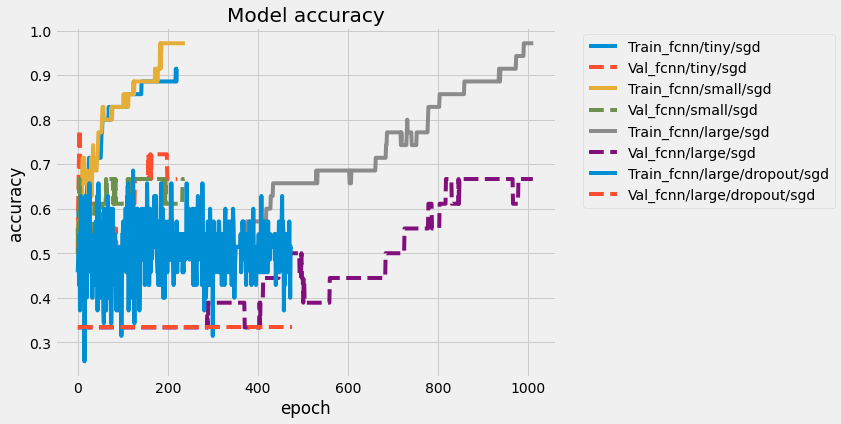

In [31]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

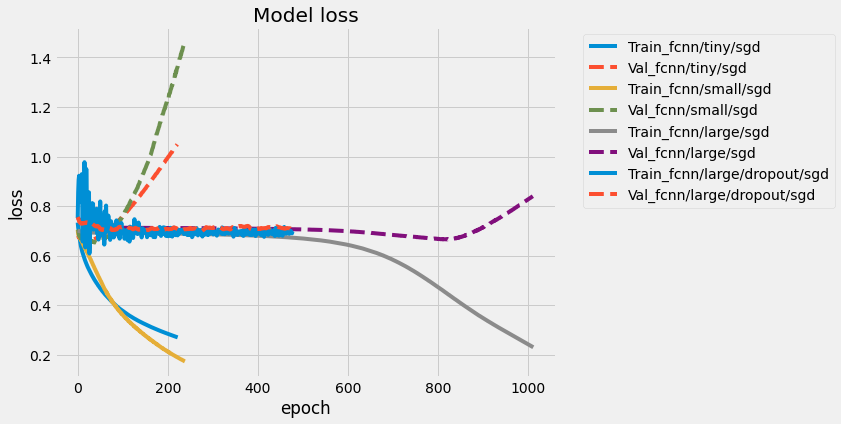

In [32]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [33]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large/sgd']
regularizer_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [34]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_1)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_2)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

regularizer_histories['fcnn/large/l2/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset, 
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              loss="binary_crossentropy",
                                            max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 263,665
Trainable params: 263,665
Non-trainable

9/9 [==============================] - 0s 3ms/step - loss: 1.1315 - accuracy: 0.8571 - val_loss: 1.1786 - val_accuracy: 0.6111
Epoch 51/5000
9/9 [==============================] - 0s 3ms/step - loss: 1.1340 - accuracy: 0.8000 - val_loss: 1.1769 - val_accuracy: 0.5556
Epoch 52/5000
9/9 [==============================] - 0s 3ms/step - loss: 1.1276 - accuracy: 0.8571 - val_loss: 1.1763 - val_accuracy: 0.6111
Epoch 53/5000
9/9 [==============================] - 0s 3ms/step - loss: 1.1273 - accuracy: 0.8286 - val_loss: 1.1754 - val_accuracy: 0.6667
Epoch 54/5000
9/9 [==============================] - 0s 3ms/step - loss: 1.1214 - accuracy: 0.8857 - val_loss: 1.1753 - val_accuracy: 0.6111
Epoch 55/5000
9/9 [==============================] - 0s 3ms/step - loss: 1.1205 - accuracy: 0.8571 - val_loss: 1.1754 - val_accuracy: 0.6667
Epoch 56/5000
9/9 [==============================] - 0s 3ms/step - loss: 1.1145 - accuracy: 0.8571 - val_loss: 1.1742 - val_accuracy: 0.6111
Epoch 57/5000
9/9 [========

9/9 [==============================] - 0s 3ms/step - loss: 0.8268 - accuracy: 0.8857 - val_loss: 1.3093 - val_accuracy: 0.6667
Epoch 109/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8263 - accuracy: 0.8857 - val_loss: 1.2907 - val_accuracy: 0.6667
Epoch 110/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8209 - accuracy: 0.8857 - val_loss: 1.2905 - val_accuracy: 0.6667
Epoch 111/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8138 - accuracy: 0.9143 - val_loss: 1.3132 - val_accuracy: 0.6667
Epoch 112/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8108 - accuracy: 0.8857 - val_loss: 1.3234 - val_accuracy: 0.6667
Epoch 113/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8072 - accuracy: 0.9143 - val_loss: 1.3094 - val_accuracy: 0.6667
Epoch 114/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8018 - accuracy: 0.9143 - val_loss: 1.3190 - val_accuracy: 0.6667
Epoch 115/5000
9/9 [=

Epoch 166/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.9714 - val_loss: 1.9456 - val_accuracy: 0.6111
Epoch 167/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.9714 - val_loss: 1.9765 - val_accuracy: 0.6111
Epoch 168/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.9714 - val_loss: 1.9972 - val_accuracy: 0.6111
Epoch 169/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.9714 - val_loss: 2.0047 - val_accuracy: 0.6111
Epoch 170/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.9714 - val_loss: 2.0192 - val_accuracy: 0.6111
Epoch 171/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.9714 - val_loss: 2.0396 - val_accuracy: 0.6111
Epoch 172/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.9714 - val_loss: 2.0562 - val_accuracy: 0.6111
Epoch 

Epoch 224/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5388 - accuracy: 1.0000 - val_loss: 2.8908 - val_accuracy: 0.6111
Epoch 225/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5378 - accuracy: 1.0000 - val_loss: 2.9026 - val_accuracy: 0.6111
Epoch 226/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5367 - accuracy: 1.0000 - val_loss: 2.9162 - val_accuracy: 0.6111
Epoch 227/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5357 - accuracy: 1.0000 - val_loss: 2.9365 - val_accuracy: 0.6111
Epoch 228/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5346 - accuracy: 1.0000 - val_loss: 2.9405 - val_accuracy: 0.6111
Epoch 229/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5338 - accuracy: 1.0000 - val_loss: 2.9569 - val_accuracy: 0.6111
Epoch 230/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.5326 - accuracy: 1.0000 - val_loss: 2.9641 - val_accuracy: 0.6111
Epoch 

In [35]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.4996 - accuracy: 1.0000
training loss : 0.499555379152298
training accuracy : 1.0
5/5 [==============================] - 0s 1ms/step - loss: 3.4311 - accuracy: 0.6111
test loss : 3.431056022644043
test accuracy : 0.6111111044883728


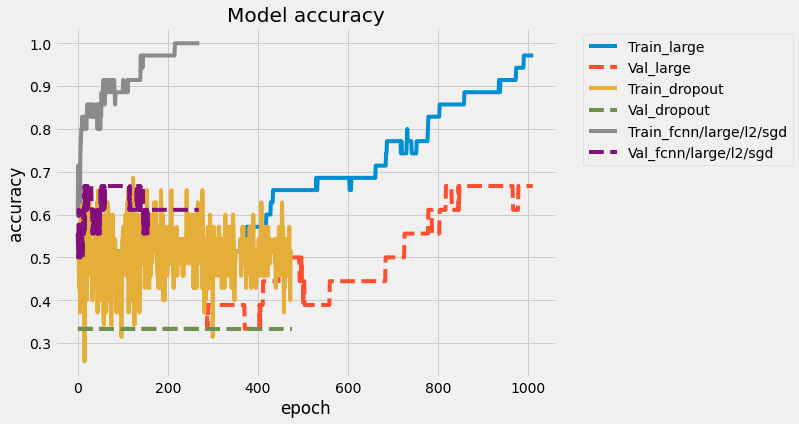

In [36]:
plot_report(regularizer_histories, 'accuracy')

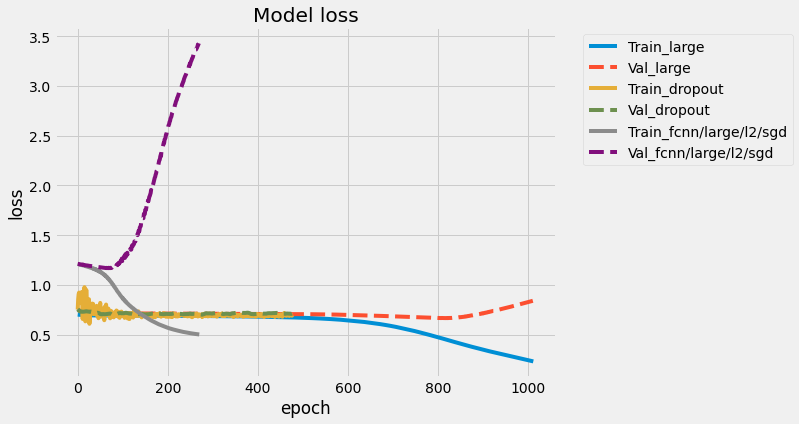

In [37]:
plot_report(regularizer_histories, 'loss')

Now let's see what happens combining both techniques

In [38]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(inputs)
dropout_1 = tf.keras.layers.Dropout(dr)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dr)(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dr)(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_3)
dropout_4 = tf.keras.layers.Dropout(dr)(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

regularizer_histories['fcnn/large/combined/sgd'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                65552     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136   

Epoch 49/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8327 - accuracy: 0.5429 - val_loss: 0.8496 - val_accuracy: 0.3333
Epoch 50/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8111 - accuracy: 0.5143 - val_loss: 0.8497 - val_accuracy: 0.3333
Epoch 51/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8325 - accuracy: 0.5714 - val_loss: 0.8493 - val_accuracy: 0.3333
Epoch 52/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8299 - accuracy: 0.4571 - val_loss: 0.8486 - val_accuracy: 0.3333
Epoch 53/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8161 - accuracy: 0.6000 - val_loss: 0.8485 - val_accuracy: 0.3333
Epoch 54/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8073 - accuracy: 0.6000 - val_loss: 0.8488 - val_accuracy: 0.3333
Epoch 55/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8144 - accuracy: 0.4857 - val_loss: 0.8490 - val_accuracy: 0.3333
Epoch 56/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.8322 - accuracy: 0.4286 - val_loss: 0.8468 - val_accuracy: 0.3333
Epoch 108/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8199 - accuracy: 0.5429 - val_loss: 0.8471 - val_accuracy: 0.3333
Epoch 109/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8192 - accuracy: 0.5143 - val_loss: 0.8474 - val_accuracy: 0.3333
Epoch 110/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8091 - accuracy: 0.5143 - val_loss: 0.8477 - val_accuracy: 0.3333
Epoch 111/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8266 - accuracy: 0.4571 - val_loss: 0.8484 - val_accuracy: 0.3333
Epoch 112/5000
9/9 [==============================] - 0s 8ms/step - loss: 0.8096 - accuracy: 0.5429 - val_loss: 0.8490 - val_accuracy: 0.3333
Epoch 113/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8391 - accuracy: 0.4857 - val_loss: 0.8497 - val_accuracy: 0.3333
Epoch 114/5000
9/9 [=

Epoch 165/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8260 - accuracy: 0.4857 - val_loss: 0.8430 - val_accuracy: 0.3333
Epoch 166/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8422 - accuracy: 0.5143 - val_loss: 0.8428 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8275 - accuracy: 0.5143 - val_loss: 0.8423 - val_accuracy: 0.3333
Epoch 168/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8188 - accuracy: 0.5429 - val_loss: 0.8423 - val_accuracy: 0.3333
Epoch 169/5000
9/9 [==============================] - 0s 8ms/step - loss: 0.7932 - accuracy: 0.6000 - val_loss: 0.8424 - val_accuracy: 0.3333
Epoch 170/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8177 - accuracy: 0.5429 - val_loss: 0.8424 - val_accuracy: 0.3333
Epoch 171/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8506 - accuracy: 0.4286 - val_loss: 0.8423 - val_accuracy: 0.3333
Epoch 

Epoch 223/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8225 - accuracy: 0.4857 - val_loss: 0.8380 - val_accuracy: 0.3333
Epoch 224/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8226 - accuracy: 0.5429 - val_loss: 0.8376 - val_accuracy: 0.3333
Epoch 225/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8226 - accuracy: 0.4286 - val_loss: 0.8376 - val_accuracy: 0.3333
Epoch 226/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8090 - accuracy: 0.5429 - val_loss: 0.8374 - val_accuracy: 0.3333
Epoch 227/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8015 - accuracy: 0.6286 - val_loss: 0.8377 - val_accuracy: 0.3333
Epoch 228/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8109 - accuracy: 0.5429 - val_loss: 0.8375 - val_accuracy: 0.3333
Epoch 229/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8284 - accuracy: 0.5429 - val_loss: 0.8372 - val_accuracy: 0.3333
Epoch 

Epoch 281/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8130 - accuracy: 0.5143 - val_loss: 0.8392 - val_accuracy: 0.3333
Epoch 282/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.8297 - accuracy: 0.5429 - val_loss: 0.8391 - val_accuracy: 0.3333
Epoch 283/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.8074 - accuracy: 0.4571 - val_loss: 0.8388 - val_accuracy: 0.3333
Epoch 284/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.8020 - accuracy: 0.5429 - val_loss: 0.8385 - val_accuracy: 0.3333
Epoch 285/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8030 - accuracy: 0.5143 - val_loss: 0.8387 - val_accuracy: 0.3333
Epoch 286/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8155 - accuracy: 0.5429 - val_loss: 0.8390 - val_accuracy: 0.3333
Epoch 287/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8140 - accuracy: 0.5714 - val_loss: 0.8387 - val_accuracy: 0.3333
Epoch 

Epoch 339/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8036 - accuracy: 0.5714 - val_loss: 0.8335 - val_accuracy: 0.3333
Epoch 340/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8043 - accuracy: 0.6286 - val_loss: 0.8331 - val_accuracy: 0.3333
Epoch 341/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7977 - accuracy: 0.6286 - val_loss: 0.8327 - val_accuracy: 0.3333
Epoch 342/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8295 - accuracy: 0.4286 - val_loss: 0.8325 - val_accuracy: 0.3333
Epoch 343/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8443 - accuracy: 0.3143 - val_loss: 0.8326 - val_accuracy: 0.3333
Epoch 344/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7858 - accuracy: 0.6000 - val_loss: 0.8326 - val_accuracy: 0.3333
Epoch 345/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8108 - accuracy: 0.5714 - val_loss: 0.8325 - val_accuracy: 0.3333
Epoch 

Epoch 397/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8162 - accuracy: 0.4571 - val_loss: 0.8301 - val_accuracy: 0.3333
Epoch 398/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8211 - accuracy: 0.5143 - val_loss: 0.8300 - val_accuracy: 0.3333
Epoch 399/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.8002 - accuracy: 0.5143 - val_loss: 0.8299 - val_accuracy: 0.3333
Epoch 400/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8195 - accuracy: 0.5429 - val_loss: 0.8300 - val_accuracy: 0.3333
Epoch 401/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8337 - accuracy: 0.4286 - val_loss: 0.8304 - val_accuracy: 0.3333
Epoch 402/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8120 - accuracy: 0.5143 - val_loss: 0.8303 - val_accuracy: 0.3333
Epoch 403/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8141 - accuracy: 0.4857 - val_loss: 0.8301 - val_accuracy: 0.3333
Epoch 

Epoch 455/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7973 - accuracy: 0.5429 - val_loss: 0.8274 - val_accuracy: 0.3333
Epoch 456/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8083 - accuracy: 0.4571 - val_loss: 0.8278 - val_accuracy: 0.3333
Epoch 457/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8067 - accuracy: 0.5143 - val_loss: 0.8281 - val_accuracy: 0.3333
Epoch 458/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8059 - accuracy: 0.5714 - val_loss: 0.8281 - val_accuracy: 0.3333
Epoch 459/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8153 - accuracy: 0.4571 - val_loss: 0.8280 - val_accuracy: 0.3333
Epoch 460/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8113 - accuracy: 0.5143 - val_loss: 0.8279 - val_accuracy: 0.3333
Epoch 461/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8064 - accuracy: 0.4571 - val_loss: 0.8278 - val_accuracy: 0.3333
Epoch 

Epoch 513/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7906 - accuracy: 0.5714 - val_loss: 0.8261 - val_accuracy: 0.3333
Epoch 514/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8229 - accuracy: 0.3429 - val_loss: 0.8262 - val_accuracy: 0.3333
Epoch 515/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8278 - accuracy: 0.4000 - val_loss: 0.8262 - val_accuracy: 0.3333
Epoch 516/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8204 - accuracy: 0.4857 - val_loss: 0.8262 - val_accuracy: 0.3333
Epoch 517/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8025 - accuracy: 0.5143 - val_loss: 0.8260 - val_accuracy: 0.3333
Epoch 518/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7856 - accuracy: 0.5429 - val_loss: 0.8260 - val_accuracy: 0.3333
Epoch 519/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8048 - accuracy: 0.5429 - val_loss: 0.8263 - val_accuracy: 0.3333
Epoch 

Epoch 571/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8045 - accuracy: 0.5714 - val_loss: 0.8229 - val_accuracy: 0.3333
Epoch 572/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8067 - accuracy: 0.5429 - val_loss: 0.8226 - val_accuracy: 0.3333
Epoch 573/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7935 - accuracy: 0.6000 - val_loss: 0.8223 - val_accuracy: 0.3333
Epoch 574/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7782 - accuracy: 0.6286 - val_loss: 0.8222 - val_accuracy: 0.3333
Epoch 575/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8242 - accuracy: 0.3714 - val_loss: 0.8225 - val_accuracy: 0.3333
Epoch 576/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7925 - accuracy: 0.5143 - val_loss: 0.8227 - val_accuracy: 0.3333
Epoch 577/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8078 - accuracy: 0.4571 - val_loss: 0.8228 - val_accuracy: 0.3333
Epoch 

Epoch 629/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7997 - accuracy: 0.6000 - val_loss: 0.8198 - val_accuracy: 0.3333
Epoch 630/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8081 - accuracy: 0.5714 - val_loss: 0.8193 - val_accuracy: 0.3333
Epoch 631/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7945 - accuracy: 0.5429 - val_loss: 0.8190 - val_accuracy: 0.3333
Epoch 632/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7957 - accuracy: 0.5714 - val_loss: 0.8189 - val_accuracy: 0.3333
Epoch 633/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8067 - accuracy: 0.5429 - val_loss: 0.8188 - val_accuracy: 0.3333
Epoch 634/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7905 - accuracy: 0.5429 - val_loss: 0.8187 - val_accuracy: 0.3333
Epoch 635/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8032 - accuracy: 0.4571 - val_loss: 0.8188 - val_accuracy: 0.3333
Epoch 

Epoch 687/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7967 - accuracy: 0.4857 - val_loss: 0.8204 - val_accuracy: 0.3333
Epoch 688/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8123 - accuracy: 0.4286 - val_loss: 0.8205 - val_accuracy: 0.3333
Epoch 689/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8076 - accuracy: 0.4857 - val_loss: 0.8201 - val_accuracy: 0.3333
Epoch 690/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7924 - accuracy: 0.5429 - val_loss: 0.8196 - val_accuracy: 0.3333
Epoch 691/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7976 - accuracy: 0.5143 - val_loss: 0.8192 - val_accuracy: 0.3333
Epoch 692/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7912 - accuracy: 0.6000 - val_loss: 0.8189 - val_accuracy: 0.3333
Epoch 693/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7901 - accuracy: 0.6000 - val_loss: 0.8185 - val_accuracy: 0.3333
Epoch 

Epoch 745/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8029 - accuracy: 0.4286 - val_loss: 0.8163 - val_accuracy: 0.3333
Epoch 746/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7991 - accuracy: 0.5143 - val_loss: 0.8163 - val_accuracy: 0.3333
Epoch 747/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8102 - accuracy: 0.4571 - val_loss: 0.8163 - val_accuracy: 0.3333
Epoch 748/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7882 - accuracy: 0.6000 - val_loss: 0.8161 - val_accuracy: 0.3333
Epoch 749/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7930 - accuracy: 0.5429 - val_loss: 0.8157 - val_accuracy: 0.3333
Epoch 750/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8048 - accuracy: 0.5143 - val_loss: 0.8157 - val_accuracy: 0.3333
Epoch 751/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7937 - accuracy: 0.5143 - val_loss: 0.8159 - val_accuracy: 0.3333
Epoch 

Epoch 803/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7746 - accuracy: 0.6857 - val_loss: 0.8131 - val_accuracy: 0.3333
Epoch 804/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7866 - accuracy: 0.6286 - val_loss: 0.8132 - val_accuracy: 0.3333
Epoch 805/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7983 - accuracy: 0.5143 - val_loss: 0.8131 - val_accuracy: 0.3333
Epoch 806/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7931 - accuracy: 0.4286 - val_loss: 0.8132 - val_accuracy: 0.3333
Epoch 807/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7971 - accuracy: 0.5143 - val_loss: 0.8132 - val_accuracy: 0.3333
Epoch 808/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7873 - accuracy: 0.5143 - val_loss: 0.8130 - val_accuracy: 0.3333
Epoch 809/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7983 - accuracy: 0.4857 - val_loss: 0.8129 - val_accuracy: 0.3333
Epoch 

Epoch 861/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7856 - accuracy: 0.5143 - val_loss: 0.8113 - val_accuracy: 0.3333
Epoch 862/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7886 - accuracy: 0.5714 - val_loss: 0.8113 - val_accuracy: 0.3333
Epoch 863/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.8105 - accuracy: 0.4000 - val_loss: 0.8111 - val_accuracy: 0.3333
Epoch 864/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7769 - accuracy: 0.6000 - val_loss: 0.8110 - val_accuracy: 0.3333
Epoch 865/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7844 - accuracy: 0.5143 - val_loss: 0.8110 - val_accuracy: 0.3333
Epoch 866/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7837 - accuracy: 0.4857 - val_loss: 0.8110 - val_accuracy: 0.3333
Epoch 867/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7930 - accuracy: 0.4857 - val_loss: 0.8107 - val_accuracy: 0.3333
Epoch 

Epoch 919/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7931 - accuracy: 0.4857 - val_loss: 0.8087 - val_accuracy: 0.3333
Epoch 920/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7956 - accuracy: 0.4571 - val_loss: 0.8089 - val_accuracy: 0.3333
Epoch 921/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7837 - accuracy: 0.5143 - val_loss: 0.8090 - val_accuracy: 0.3333
Epoch 922/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7975 - accuracy: 0.4857 - val_loss: 0.8088 - val_accuracy: 0.3333
Epoch 923/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7889 - accuracy: 0.5429 - val_loss: 0.8083 - val_accuracy: 0.3333
Epoch 924/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7882 - accuracy: 0.4857 - val_loss: 0.8082 - val_accuracy: 0.3333
Epoch 925/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7741 - accuracy: 0.4857 - val_loss: 0.8082 - val_accuracy: 0.3333
Epoch 

Epoch 977/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7924 - accuracy: 0.4286 - val_loss: 0.8058 - val_accuracy: 0.3333
Epoch 978/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7907 - accuracy: 0.4571 - val_loss: 0.8059 - val_accuracy: 0.3333
Epoch 979/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7801 - accuracy: 0.5143 - val_loss: 0.8057 - val_accuracy: 0.3333
Epoch 980/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7797 - accuracy: 0.5429 - val_loss: 0.8056 - val_accuracy: 0.3333
Epoch 981/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7883 - accuracy: 0.5143 - val_loss: 0.8054 - val_accuracy: 0.3333
Epoch 982/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7840 - accuracy: 0.4857 - val_loss: 0.8053 - val_accuracy: 0.3333
Epoch 983/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7865 - accuracy: 0.5429 - val_loss: 0.8053 - val_accuracy: 0.3333
Epoch 

9/9 [==============================] - 0s 3ms/step - loss: 0.7795 - accuracy: 0.5143 - val_loss: 0.8029 - val_accuracy: 0.3333
Epoch 1035/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7698 - accuracy: 0.5714 - val_loss: 0.8026 - val_accuracy: 0.3333
Epoch 1036/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7786 - accuracy: 0.5143 - val_loss: 0.8026 - val_accuracy: 0.3333
Epoch 1037/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7917 - accuracy: 0.4286 - val_loss: 0.8026 - val_accuracy: 0.3333
Epoch 1038/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7825 - accuracy: 0.5143 - val_loss: 0.8026 - val_accuracy: 0.3333
Epoch 1039/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7843 - accuracy: 0.5714 - val_loss: 0.8024 - val_accuracy: 0.3333
Epoch 1040/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7762 - accuracy: 0.4571 - val_loss: 0.8023 - val_accuracy: 0.3333
Epoch 1041/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7773 - accuracy: 0.5429 - val_loss: 0.8008 - val_accuracy: 0.3333
Epoch 1092/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7820 - accuracy: 0.5143 - val_loss: 0.8007 - val_accuracy: 0.3333
Epoch 1093/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7843 - accuracy: 0.4857 - val_loss: 0.8005 - val_accuracy: 0.3333
Epoch 1094/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7820 - accuracy: 0.5714 - val_loss: 0.8004 - val_accuracy: 0.3333
Epoch 1095/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7842 - accuracy: 0.4286 - val_loss: 0.8003 - val_accuracy: 0.3333
Epoch 1096/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7865 - accuracy: 0.4571 - val_loss: 0.8002 - val_accuracy: 0.3333
Epoch 1097/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7684 - accuracy: 0.5429 - val_loss: 0.8003 - val_accuracy: 0.3333
Epoch 1098/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7852 - accuracy: 0.4286 - val_loss: 0.7993 - val_accuracy: 0.3333
Epoch 1149/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7767 - accuracy: 0.5429 - val_loss: 0.7992 - val_accuracy: 0.3333
Epoch 1150/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7738 - accuracy: 0.5714 - val_loss: 0.7991 - val_accuracy: 0.3333
Epoch 1151/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7820 - accuracy: 0.4857 - val_loss: 0.7992 - val_accuracy: 0.3333
Epoch 1152/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7702 - accuracy: 0.6000 - val_loss: 0.7992 - val_accuracy: 0.3333
Epoch 1153/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7838 - accuracy: 0.4857 - val_loss: 0.7989 - val_accuracy: 0.3333
Epoch 1154/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7828 - accuracy: 0.5143 - val_loss: 0.7987 - val_accuracy: 0.3333
Epoch 1155/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7817 - accuracy: 0.4857 - val_loss: 0.7976 - val_accuracy: 0.3333
Epoch 1206/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7781 - accuracy: 0.5429 - val_loss: 0.7976 - val_accuracy: 0.3333
Epoch 1207/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7721 - accuracy: 0.5429 - val_loss: 0.7977 - val_accuracy: 0.3333
Epoch 1208/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7805 - accuracy: 0.4857 - val_loss: 0.7978 - val_accuracy: 0.3333
Epoch 1209/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7814 - accuracy: 0.5143 - val_loss: 0.7980 - val_accuracy: 0.3333
Epoch 1210/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7809 - accuracy: 0.4857 - val_loss: 0.7982 - val_accuracy: 0.3333
Epoch 1211/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7764 - accuracy: 0.4857 - val_loss: 0.7983 - val_accuracy: 0.3333
Epoch 1212/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7714 - accuracy: 0.6286 - val_loss: 0.7950 - val_accuracy: 0.3333
Epoch 1263/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7780 - accuracy: 0.5429 - val_loss: 0.7950 - val_accuracy: 0.3333
Epoch 1264/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7814 - accuracy: 0.4571 - val_loss: 0.7950 - val_accuracy: 0.3333
Epoch 1265/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7818 - accuracy: 0.4857 - val_loss: 0.7947 - val_accuracy: 0.3333
Epoch 1266/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7676 - accuracy: 0.4857 - val_loss: 0.7946 - val_accuracy: 0.3333
Epoch 1267/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7711 - accuracy: 0.5143 - val_loss: 0.7945 - val_accuracy: 0.3333
Epoch 1268/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7743 - accuracy: 0.5429 - val_loss: 0.7943 - val_accuracy: 0.3333
Epoch 1269/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7807 - accuracy: 0.5143 - val_loss: 0.7917 - val_accuracy: 0.3333
Epoch 1320/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7753 - accuracy: 0.5429 - val_loss: 0.7918 - val_accuracy: 0.3333
Epoch 1321/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7767 - accuracy: 0.4571 - val_loss: 0.7920 - val_accuracy: 0.3333
Epoch 1322/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7709 - accuracy: 0.4286 - val_loss: 0.7922 - val_accuracy: 0.3333
Epoch 1323/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7748 - accuracy: 0.4857 - val_loss: 0.7922 - val_accuracy: 0.3333
Epoch 1324/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7718 - accuracy: 0.5143 - val_loss: 0.7921 - val_accuracy: 0.3333
Epoch 1325/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7756 - accuracy: 0.4857 - val_loss: 0.7922 - val_accuracy: 0.3333
Epoch 1326/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7620 - accuracy: 0.5429 - val_loss: 0.7902 - val_accuracy: 0.3333
Epoch 1377/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7756 - accuracy: 0.4857 - val_loss: 0.7901 - val_accuracy: 0.3333
Epoch 1378/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7696 - accuracy: 0.4857 - val_loss: 0.7898 - val_accuracy: 0.3333
Epoch 1379/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7778 - accuracy: 0.4286 - val_loss: 0.7897 - val_accuracy: 0.3333
Epoch 1380/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7776 - accuracy: 0.4857 - val_loss: 0.7899 - val_accuracy: 0.3333
Epoch 1381/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7863 - accuracy: 0.4857 - val_loss: 0.7900 - val_accuracy: 0.3333
Epoch 1382/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7724 - accuracy: 0.4857 - val_loss: 0.7898 - val_accuracy: 0.3333
Epoch 1383/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7624 - accuracy: 0.5714 - val_loss: 0.7883 - val_accuracy: 0.3333
Epoch 1434/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7814 - accuracy: 0.4000 - val_loss: 0.7882 - val_accuracy: 0.3333
Epoch 1435/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7773 - accuracy: 0.5143 - val_loss: 0.7883 - val_accuracy: 0.3333
Epoch 1436/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7640 - accuracy: 0.4857 - val_loss: 0.7885 - val_accuracy: 0.3333
Epoch 1437/5000
9/9 [==============================] - 0s 5ms/step - loss: 0.7809 - accuracy: 0.4857 - val_loss: 0.7884 - val_accuracy: 0.3333
Epoch 1438/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7676 - accuracy: 0.4857 - val_loss: 0.7881 - val_accuracy: 0.3333
Epoch 1439/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7711 - accuracy: 0.5143 - val_loss: 0.7877 - val_accuracy: 0.3333
Epoch 1440/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7628 - accuracy: 0.5714 - val_loss: 0.7863 - val_accuracy: 0.3333
Epoch 1491/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7587 - accuracy: 0.5429 - val_loss: 0.7863 - val_accuracy: 0.3333
Epoch 1492/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7589 - accuracy: 0.4571 - val_loss: 0.7860 - val_accuracy: 0.3333
Epoch 1493/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7698 - accuracy: 0.4857 - val_loss: 0.7859 - val_accuracy: 0.3333
Epoch 1494/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7779 - accuracy: 0.4571 - val_loss: 0.7859 - val_accuracy: 0.3333
Epoch 1495/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7647 - accuracy: 0.5714 - val_loss: 0.7859 - val_accuracy: 0.3333
Epoch 1496/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7710 - accuracy: 0.4000 - val_loss: 0.7861 - val_accuracy: 0.3333
Epoch 1497/5000

9/9 [==============================] - 0s 2ms/step - loss: 0.7582 - accuracy: 0.4571 - val_loss: 0.7868 - val_accuracy: 0.3333
Epoch 1548/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7646 - accuracy: 0.4571 - val_loss: 0.7872 - val_accuracy: 0.3333
Epoch 1549/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7620 - accuracy: 0.4571 - val_loss: 0.7878 - val_accuracy: 0.3333
Epoch 1550/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7622 - accuracy: 0.6000 - val_loss: 0.7880 - val_accuracy: 0.3333
Epoch 1551/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7651 - accuracy: 0.4857 - val_loss: 0.7882 - val_accuracy: 0.3333
Epoch 1552/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7683 - accuracy: 0.5143 - val_loss: 0.7882 - val_accuracy: 0.3333
Epoch 1553/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7629 - accuracy: 0.5143 - val_loss: 0.7880 - val_accuracy: 0.3333
Epoch 1554/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7612 - accuracy: 0.5429 - val_loss: 0.7852 - val_accuracy: 0.3333
Epoch 1605/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7681 - accuracy: 0.4857 - val_loss: 0.7850 - val_accuracy: 0.3333
Epoch 1606/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7665 - accuracy: 0.4286 - val_loss: 0.7848 - val_accuracy: 0.3333
Epoch 1607/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7660 - accuracy: 0.5429 - val_loss: 0.7847 - val_accuracy: 0.3333
Epoch 1608/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7628 - accuracy: 0.4571 - val_loss: 0.7846 - val_accuracy: 0.3333
Epoch 1609/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7645 - accuracy: 0.5429 - val_loss: 0.7845 - val_accuracy: 0.3333
Epoch 1610/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7558 - accuracy: 0.5143 - val_loss: 0.7844 - val_accuracy: 0.3333
Epoch 1611/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7581 - accuracy: 0.4857 - val_loss: 0.7828 - val_accuracy: 0.3333
Epoch 1662/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7582 - accuracy: 0.4857 - val_loss: 0.7827 - val_accuracy: 0.3333
Epoch 1663/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7645 - accuracy: 0.5714 - val_loss: 0.7829 - val_accuracy: 0.3333
Epoch 1664/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7726 - accuracy: 0.5143 - val_loss: 0.7829 - val_accuracy: 0.3333
Epoch 1665/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7670 - accuracy: 0.4857 - val_loss: 0.7826 - val_accuracy: 0.3333
Epoch 1666/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7751 - accuracy: 0.4571 - val_loss: 0.7822 - val_accuracy: 0.3333
Epoch 1667/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7550 - accuracy: 0.5714 - val_loss: 0.7820 - val_accuracy: 0.3333
Epoch 1668/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7511 - accuracy: 0.5714 - val_loss: 0.7806 - val_accuracy: 0.3333
Epoch 1719/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7633 - accuracy: 0.5714 - val_loss: 0.7802 - val_accuracy: 0.3333
Epoch 1720/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7545 - accuracy: 0.4857 - val_loss: 0.7800 - val_accuracy: 0.3333
Epoch 1721/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7614 - accuracy: 0.4857 - val_loss: 0.7798 - val_accuracy: 0.3333
Epoch 1722/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7539 - accuracy: 0.5714 - val_loss: 0.7797 - val_accuracy: 0.3333
Epoch 1723/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7460 - accuracy: 0.5143 - val_loss: 0.7798 - val_accuracy: 0.3333
Epoch 1724/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.5714 - val_loss: 0.7797 - val_accuracy: 0.3333
Epoch 1725/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7568 - accuracy: 0.5429 - val_loss: 0.7782 - val_accuracy: 0.3333
Epoch 1776/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7575 - accuracy: 0.5143 - val_loss: 0.7782 - val_accuracy: 0.3333
Epoch 1777/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7580 - accuracy: 0.4857 - val_loss: 0.7784 - val_accuracy: 0.3333
Epoch 1778/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7517 - accuracy: 0.5429 - val_loss: 0.7785 - val_accuracy: 0.3333
Epoch 1779/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7593 - accuracy: 0.4857 - val_loss: 0.7784 - val_accuracy: 0.3333
Epoch 1780/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7533 - accuracy: 0.5714 - val_loss: 0.7783 - val_accuracy: 0.3333
Epoch 1781/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7628 - accuracy: 0.5143 - val_loss: 0.7780 - val_accuracy: 0.3333
Epoch 1782/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7530 - accuracy: 0.5143 - val_loss: 0.7761 - val_accuracy: 0.3333
Epoch 1833/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7541 - accuracy: 0.5143 - val_loss: 0.7761 - val_accuracy: 0.3333
Epoch 1834/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7557 - accuracy: 0.5143 - val_loss: 0.7761 - val_accuracy: 0.3333
Epoch 1835/5000
9/9 [==============================] - 0s 6ms/step - loss: 0.7476 - accuracy: 0.5143 - val_loss: 0.7762 - val_accuracy: 0.3333
Epoch 1836/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7546 - accuracy: 0.4857 - val_loss: 0.7762 - val_accuracy: 0.3333
Epoch 1837/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7537 - accuracy: 0.4857 - val_loss: 0.7765 - val_accuracy: 0.3333
Epoch 1838/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7589 - accuracy: 0.5429 - val_loss: 0.7764 - val_accuracy: 0.3333
Epoch 1839/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7524 - accuracy: 0.4857 - val_loss: 0.7733 - val_accuracy: 0.3333
Epoch 1890/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7475 - accuracy: 0.5429 - val_loss: 0.7734 - val_accuracy: 0.3333
Epoch 1891/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7570 - accuracy: 0.4571 - val_loss: 0.7736 - val_accuracy: 0.3333
Epoch 1892/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7534 - accuracy: 0.4857 - val_loss: 0.7736 - val_accuracy: 0.3333
Epoch 1893/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7531 - accuracy: 0.5143 - val_loss: 0.7737 - val_accuracy: 0.3333
Epoch 1894/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7491 - accuracy: 0.5429 - val_loss: 0.7737 - val_accuracy: 0.3333
Epoch 1895/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7516 - accuracy: 0.4857 - val_loss: 0.7736 - val_accuracy: 0.3333
Epoch 1896/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7461 - accuracy: 0.4857 - val_loss: 0.7733 - val_accuracy: 0.3333
Epoch 1947/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7558 - accuracy: 0.4857 - val_loss: 0.7733 - val_accuracy: 0.3333
Epoch 1948/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7581 - accuracy: 0.4571 - val_loss: 0.7732 - val_accuracy: 0.3333
Epoch 1949/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7515 - accuracy: 0.5429 - val_loss: 0.7732 - val_accuracy: 0.3333
Epoch 1950/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7608 - accuracy: 0.5143 - val_loss: 0.7730 - val_accuracy: 0.3333
Epoch 1951/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7505 - accuracy: 0.4857 - val_loss: 0.7729 - val_accuracy: 0.3333
Epoch 1952/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7544 - accuracy: 0.5429 - val_loss: 0.7728 - val_accuracy: 0.3333
Epoch 1953/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7438 - accuracy: 0.5429 - val_loss: 0.7702 - val_accuracy: 0.3333
Epoch 2004/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7517 - accuracy: 0.4857 - val_loss: 0.7704 - val_accuracy: 0.3333
Epoch 2005/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7461 - accuracy: 0.4857 - val_loss: 0.7704 - val_accuracy: 0.3333
Epoch 2006/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7553 - accuracy: 0.4571 - val_loss: 0.7705 - val_accuracy: 0.3333
Epoch 2007/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7559 - accuracy: 0.4857 - val_loss: 0.7704 - val_accuracy: 0.3333
Epoch 2008/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7462 - accuracy: 0.5429 - val_loss: 0.7705 - val_accuracy: 0.3333
Epoch 2009/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7416 - accuracy: 0.5714 - val_loss: 0.7707 - val_accuracy: 0.3333
Epoch 2010/5000

9/9 [==============================] - 0s 4ms/step - loss: 0.7566 - accuracy: 0.5143 - val_loss: 0.7684 - val_accuracy: 0.3333
Epoch 2061/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7490 - accuracy: 0.5143 - val_loss: 0.7683 - val_accuracy: 0.3333
Epoch 2062/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7431 - accuracy: 0.5714 - val_loss: 0.7686 - val_accuracy: 0.3333
Epoch 2063/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7512 - accuracy: 0.5143 - val_loss: 0.7686 - val_accuracy: 0.3333
Epoch 2064/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7492 - accuracy: 0.4857 - val_loss: 0.7687 - val_accuracy: 0.3333
Epoch 2065/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7539 - accuracy: 0.5143 - val_loss: 0.7686 - val_accuracy: 0.3333
Epoch 2066/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7391 - accuracy: 0.5143 - val_loss: 0.7686 - val_accuracy: 0.3333
Epoch 2067/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7469 - accuracy: 0.5143 - val_loss: 0.7672 - val_accuracy: 0.3333
Epoch 2118/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7476 - accuracy: 0.4857 - val_loss: 0.7672 - val_accuracy: 0.3333
Epoch 2119/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7454 - accuracy: 0.5143 - val_loss: 0.7674 - val_accuracy: 0.3333
Epoch 2120/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7457 - accuracy: 0.5429 - val_loss: 0.7674 - val_accuracy: 0.3333
Epoch 2121/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7413 - accuracy: 0.4857 - val_loss: 0.7675 - val_accuracy: 0.3333
Epoch 2122/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7427 - accuracy: 0.5429 - val_loss: 0.7675 - val_accuracy: 0.3333
Epoch 2123/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7533 - accuracy: 0.4571 - val_loss: 0.7675 - val_accuracy: 0.3333
Epoch 2124/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7410 - accuracy: 0.5429 - val_loss: 0.7646 - val_accuracy: 0.3333
Epoch 2175/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7497 - accuracy: 0.5143 - val_loss: 0.7645 - val_accuracy: 0.3333
Epoch 2176/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7431 - accuracy: 0.5143 - val_loss: 0.7647 - val_accuracy: 0.3333
Epoch 2177/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7365 - accuracy: 0.5714 - val_loss: 0.7647 - val_accuracy: 0.3333
Epoch 2178/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7435 - accuracy: 0.5143 - val_loss: 0.7646 - val_accuracy: 0.3333
Epoch 2179/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7393 - accuracy: 0.5429 - val_loss: 0.7645 - val_accuracy: 0.3333
Epoch 2180/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7517 - accuracy: 0.4571 - val_loss: 0.7646 - val_accuracy: 0.3333
Epoch 2181/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7461 - accuracy: 0.4857 - val_loss: 0.7626 - val_accuracy: 0.3333
Epoch 2232/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7506 - accuracy: 0.4857 - val_loss: 0.7623 - val_accuracy: 0.3333
Epoch 2233/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7421 - accuracy: 0.5143 - val_loss: 0.7623 - val_accuracy: 0.3333
Epoch 2234/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7349 - accuracy: 0.5143 - val_loss: 0.7623 - val_accuracy: 0.3333
Epoch 2235/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7395 - accuracy: 0.5143 - val_loss: 0.7623 - val_accuracy: 0.3333
Epoch 2236/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7425 - accuracy: 0.5143 - val_loss: 0.7623 - val_accuracy: 0.3333
Epoch 2237/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7449 - accuracy: 0.5429 - val_loss: 0.7623 - val_accuracy: 0.3333
Epoch 2238/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7409 - accuracy: 0.5429 - val_loss: 0.7624 - val_accuracy: 0.3333
Epoch 2289/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7540 - accuracy: 0.4286 - val_loss: 0.7622 - val_accuracy: 0.3333
Epoch 2290/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7349 - accuracy: 0.5429 - val_loss: 0.7621 - val_accuracy: 0.3333
Epoch 2291/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7465 - accuracy: 0.4857 - val_loss: 0.7620 - val_accuracy: 0.3333
Epoch 2292/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7455 - accuracy: 0.5143 - val_loss: 0.7618 - val_accuracy: 0.3333
Epoch 2293/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7373 - accuracy: 0.5429 - val_loss: 0.7615 - val_accuracy: 0.3333
Epoch 2294/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7496 - accuracy: 0.4857 - val_loss: 0.7613 - val_accuracy: 0.3333
Epoch 2295/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7346 - accuracy: 0.5143 - val_loss: 0.7585 - val_accuracy: 0.3333
Epoch 2346/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7487 - accuracy: 0.4857 - val_loss: 0.7585 - val_accuracy: 0.3333
Epoch 2347/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7481 - accuracy: 0.4857 - val_loss: 0.7584 - val_accuracy: 0.3333
Epoch 2348/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7332 - accuracy: 0.5429 - val_loss: 0.7583 - val_accuracy: 0.3333
Epoch 2349/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7465 - accuracy: 0.5143 - val_loss: 0.7582 - val_accuracy: 0.3333
Epoch 2350/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7379 - accuracy: 0.4857 - val_loss: 0.7581 - val_accuracy: 0.3333
Epoch 2351/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7389 - accuracy: 0.5143 - val_loss: 0.7580 - val_accuracy: 0.3333
Epoch 2352/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7345 - accuracy: 0.5429 - val_loss: 0.7570 - val_accuracy: 0.3333
Epoch 2403/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7378 - accuracy: 0.4857 - val_loss: 0.7569 - val_accuracy: 0.3333
Epoch 2404/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7287 - accuracy: 0.5714 - val_loss: 0.7567 - val_accuracy: 0.3333
Epoch 2405/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7471 - accuracy: 0.4857 - val_loss: 0.7565 - val_accuracy: 0.3333
Epoch 2406/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7430 - accuracy: 0.5143 - val_loss: 0.7566 - val_accuracy: 0.3333
Epoch 2407/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7384 - accuracy: 0.5429 - val_loss: 0.7566 - val_accuracy: 0.3333
Epoch 2408/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7411 - accuracy: 0.5429 - val_loss: 0.7568 - val_accuracy: 0.3333
Epoch 2409/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7388 - accuracy: 0.5143 - val_loss: 0.7568 - val_accuracy: 0.3333
Epoch 2460/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7391 - accuracy: 0.5143 - val_loss: 0.7568 - val_accuracy: 0.3333
Epoch 2461/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7371 - accuracy: 0.5143 - val_loss: 0.7567 - val_accuracy: 0.3333
Epoch 2462/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7380 - accuracy: 0.5143 - val_loss: 0.7568 - val_accuracy: 0.3333
Epoch 2463/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7471 - accuracy: 0.5143 - val_loss: 0.7568 - val_accuracy: 0.3333
Epoch 2464/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7292 - accuracy: 0.5143 - val_loss: 0.7569 - val_accuracy: 0.3333
Epoch 2465/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7324 - accuracy: 0.4857 - val_loss: 0.7571 - val_accuracy: 0.3333
Epoch 2466/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7376 - accuracy: 0.4857 - val_loss: 0.7565 - val_accuracy: 0.3333
Epoch 2517/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7308 - accuracy: 0.4857 - val_loss: 0.7565 - val_accuracy: 0.3333
Epoch 2518/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7371 - accuracy: 0.5429 - val_loss: 0.7561 - val_accuracy: 0.3333
Epoch 2519/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7284 - accuracy: 0.5429 - val_loss: 0.7556 - val_accuracy: 0.3333
Epoch 2520/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7358 - accuracy: 0.4857 - val_loss: 0.7552 - val_accuracy: 0.3333
Epoch 2521/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7314 - accuracy: 0.4857 - val_loss: 0.7553 - val_accuracy: 0.3333
Epoch 2522/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7399 - accuracy: 0.5143 - val_loss: 0.7553 - val_accuracy: 0.3333
Epoch 2523/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7343 - accuracy: 0.5143 - val_loss: 0.7553 - val_accuracy: 0.3333
Epoch 2574/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7329 - accuracy: 0.5143 - val_loss: 0.7554 - val_accuracy: 0.3333
Epoch 2575/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7292 - accuracy: 0.5143 - val_loss: 0.7553 - val_accuracy: 0.3333
Epoch 2576/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7354 - accuracy: 0.4857 - val_loss: 0.7552 - val_accuracy: 0.3333
Epoch 2577/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7356 - accuracy: 0.5143 - val_loss: 0.7553 - val_accuracy: 0.3333
Epoch 2578/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7332 - accuracy: 0.4857 - val_loss: 0.7556 - val_accuracy: 0.3333
Epoch 2579/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7383 - accuracy: 0.4286 - val_loss: 0.7558 - val_accuracy: 0.3333
Epoch 2580/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7405 - accuracy: 0.4857 - val_loss: 0.7529 - val_accuracy: 0.3333
Epoch 2631/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.5143 - val_loss: 0.7527 - val_accuracy: 0.3333
Epoch 2632/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.5429 - val_loss: 0.7525 - val_accuracy: 0.3333
Epoch 2633/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7365 - accuracy: 0.4857 - val_loss: 0.7523 - val_accuracy: 0.3333
Epoch 2634/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7270 - accuracy: 0.4857 - val_loss: 0.7524 - val_accuracy: 0.3333
Epoch 2635/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7388 - accuracy: 0.4571 - val_loss: 0.7523 - val_accuracy: 0.3333
Epoch 2636/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7386 - accuracy: 0.4571 - val_loss: 0.7522 - val_accuracy: 0.3333
Epoch 2637/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.5429 - val_loss: 0.7518 - val_accuracy: 0.3333
Epoch 2688/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7314 - accuracy: 0.5143 - val_loss: 0.7519 - val_accuracy: 0.3333
Epoch 2689/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.5429 - val_loss: 0.7517 - val_accuracy: 0.3333
Epoch 2690/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7367 - accuracy: 0.5143 - val_loss: 0.7515 - val_accuracy: 0.3333
Epoch 2691/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7270 - accuracy: 0.5143 - val_loss: 0.7512 - val_accuracy: 0.3333
Epoch 2692/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.5429 - val_loss: 0.7513 - val_accuracy: 0.3333
Epoch 2693/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7286 - accuracy: 0.4571 - val_loss: 0.7513 - val_accuracy: 0.3333
Epoch 2694/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7322 - accuracy: 0.4857 - val_loss: 0.7513 - val_accuracy: 0.3333
Epoch 2745/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7315 - accuracy: 0.5429 - val_loss: 0.7513 - val_accuracy: 0.3333
Epoch 2746/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7307 - accuracy: 0.4857 - val_loss: 0.7510 - val_accuracy: 0.3333
Epoch 2747/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7399 - accuracy: 0.5143 - val_loss: 0.7510 - val_accuracy: 0.3333
Epoch 2748/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7249 - accuracy: 0.5143 - val_loss: 0.7509 - val_accuracy: 0.3333
Epoch 2749/5000
9/9 [==============================] - 0s 7ms/step - loss: 0.7287 - accuracy: 0.5429 - val_loss: 0.7511 - val_accuracy: 0.3333
Epoch 2750/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7279 - accuracy: 0.5143 - val_loss: 0.7511 - val_accuracy: 0.3333
Epoch 2751/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7315 - accuracy: 0.5143 - val_loss: 0.7505 - val_accuracy: 0.3333
Epoch 2802/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7238 - accuracy: 0.5143 - val_loss: 0.7503 - val_accuracy: 0.3333
Epoch 2803/5000
9/9 [==============================] - 0s 6ms/step - loss: 0.7315 - accuracy: 0.5143 - val_loss: 0.7502 - val_accuracy: 0.3333
Epoch 2804/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.5143 - val_loss: 0.7501 - val_accuracy: 0.3333
Epoch 2805/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7325 - accuracy: 0.4857 - val_loss: 0.7501 - val_accuracy: 0.3333
Epoch 2806/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7351 - accuracy: 0.4571 - val_loss: 0.7501 - val_accuracy: 0.3333
Epoch 2807/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7330 - accuracy: 0.5429 - val_loss: 0.7500 - val_accuracy: 0.3333
Epoch 2808/5000

9/9 [==============================] - 0s 7ms/step - loss: 0.7326 - accuracy: 0.5143 - val_loss: 0.7482 - val_accuracy: 0.3333
Epoch 2859/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7375 - accuracy: 0.5143 - val_loss: 0.7480 - val_accuracy: 0.3333
Epoch 2860/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.5143 - val_loss: 0.7479 - val_accuracy: 0.3333
Epoch 2861/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.4857 - val_loss: 0.7479 - val_accuracy: 0.3333
Epoch 2862/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.5429 - val_loss: 0.7480 - val_accuracy: 0.3333
Epoch 2863/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.5143 - val_loss: 0.7479 - val_accuracy: 0.3333
Epoch 2864/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7361 - accuracy: 0.5143 - val_loss: 0.7478 - val_accuracy: 0.3333
Epoch 2865/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.5143 - val_loss: 0.7471 - val_accuracy: 0.3333
Epoch 2916/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7288 - accuracy: 0.4857 - val_loss: 0.7473 - val_accuracy: 0.3333
Epoch 2917/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7218 - accuracy: 0.5429 - val_loss: 0.7473 - val_accuracy: 0.3333
Epoch 2918/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7325 - accuracy: 0.5143 - val_loss: 0.7474 - val_accuracy: 0.3333
Epoch 2919/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7373 - accuracy: 0.4571 - val_loss: 0.7475 - val_accuracy: 0.3333
Epoch 2920/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7377 - accuracy: 0.4571 - val_loss: 0.7475 - val_accuracy: 0.3333
Epoch 2921/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5143 - val_loss: 0.7473 - val_accuracy: 0.3333
Epoch 2922/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7251 - accuracy: 0.4571 - val_loss: 0.7458 - val_accuracy: 0.3333
Epoch 2973/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.4857 - val_loss: 0.7456 - val_accuracy: 0.3333
Epoch 2974/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.5429 - val_loss: 0.7454 - val_accuracy: 0.3333
Epoch 2975/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5143 - val_loss: 0.7452 - val_accuracy: 0.3333
Epoch 2976/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7245 - accuracy: 0.5143 - val_loss: 0.7452 - val_accuracy: 0.3333
Epoch 2977/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7209 - accuracy: 0.5429 - val_loss: 0.7454 - val_accuracy: 0.3333
Epoch 2978/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5429 - val_loss: 0.7456 - val_accuracy: 0.3333
Epoch 2979/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7260 - accuracy: 0.4857 - val_loss: 0.7444 - val_accuracy: 0.3333
Epoch 3030/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7181 - accuracy: 0.5143 - val_loss: 0.7446 - val_accuracy: 0.3333
Epoch 3031/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7206 - accuracy: 0.5143 - val_loss: 0.7446 - val_accuracy: 0.3333
Epoch 3032/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7281 - accuracy: 0.4857 - val_loss: 0.7445 - val_accuracy: 0.3333
Epoch 3033/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.5143 - val_loss: 0.7446 - val_accuracy: 0.3333
Epoch 3034/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.5143 - val_loss: 0.7445 - val_accuracy: 0.3333
Epoch 3035/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.4857 - val_loss: 0.7443 - val_accuracy: 0.3333
Epoch 3036/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.5143 - val_loss: 0.7436 - val_accuracy: 0.3333
Epoch 3087/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7257 - accuracy: 0.5143 - val_loss: 0.7435 - val_accuracy: 0.3333
Epoch 3088/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7306 - accuracy: 0.4571 - val_loss: 0.7434 - val_accuracy: 0.3333
Epoch 3089/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.5143 - val_loss: 0.7436 - val_accuracy: 0.3333
Epoch 3090/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7287 - accuracy: 0.4857 - val_loss: 0.7437 - val_accuracy: 0.3333
Epoch 3091/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7240 - accuracy: 0.5143 - val_loss: 0.7438 - val_accuracy: 0.3333
Epoch 3092/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.5143 - val_loss: 0.7440 - val_accuracy: 0.3333
Epoch 3093/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7225 - accuracy: 0.5429 - val_loss: 0.7411 - val_accuracy: 0.3333
Epoch 3144/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7225 - accuracy: 0.4857 - val_loss: 0.7412 - val_accuracy: 0.3333
Epoch 3145/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5429 - val_loss: 0.7413 - val_accuracy: 0.3333
Epoch 3146/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5429 - val_loss: 0.7415 - val_accuracy: 0.3333
Epoch 3147/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5429 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3148/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.4857 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3149/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7273 - accuracy: 0.5143 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3150/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5429 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3201/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7189 - accuracy: 0.5143 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3202/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.5429 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3203/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7172 - accuracy: 0.5143 - val_loss: 0.7417 - val_accuracy: 0.3333
Epoch 3204/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.5143 - val_loss: 0.7417 - val_accuracy: 0.3333
Epoch 3205/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.5143 - val_loss: 0.7417 - val_accuracy: 0.3333
Epoch 3206/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7270 - accuracy: 0.5143 - val_loss: 0.7416 - val_accuracy: 0.3333
Epoch 3207/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7182 - accuracy: 0.5143 - val_loss: 0.7411 - val_accuracy: 0.3333
Epoch 3258/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.5143 - val_loss: 0.7412 - val_accuracy: 0.3333
Epoch 3259/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5143 - val_loss: 0.7413 - val_accuracy: 0.3333
Epoch 3260/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7287 - accuracy: 0.4857 - val_loss: 0.7413 - val_accuracy: 0.3333
Epoch 3261/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7260 - accuracy: 0.5143 - val_loss: 0.7412 - val_accuracy: 0.3333
Epoch 3262/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.4857 - val_loss: 0.7411 - val_accuracy: 0.3333
Epoch 3263/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5143 - val_loss: 0.7409 - val_accuracy: 0.3333
Epoch 3264/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7178 - accuracy: 0.5143 - val_loss: 0.7385 - val_accuracy: 0.3333
Epoch 3315/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7318 - accuracy: 0.4571 - val_loss: 0.7387 - val_accuracy: 0.3333
Epoch 3316/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.5143 - val_loss: 0.7386 - val_accuracy: 0.3333
Epoch 3317/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7263 - accuracy: 0.5143 - val_loss: 0.7385 - val_accuracy: 0.3333
Epoch 3318/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7207 - accuracy: 0.4571 - val_loss: 0.7384 - val_accuracy: 0.3333
Epoch 3319/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.4571 - val_loss: 0.7381 - val_accuracy: 0.3333
Epoch 3320/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5143 - val_loss: 0.7379 - val_accuracy: 0.3333
Epoch 3321/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.5714 - val_loss: 0.7376 - val_accuracy: 0.3333
Epoch 3372/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5429 - val_loss: 0.7379 - val_accuracy: 0.3333
Epoch 3373/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.5429 - val_loss: 0.7381 - val_accuracy: 0.3333
Epoch 3374/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.5143 - val_loss: 0.7381 - val_accuracy: 0.3333
Epoch 3375/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7206 - accuracy: 0.5143 - val_loss: 0.7380 - val_accuracy: 0.3333
Epoch 3376/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.4857 - val_loss: 0.7379 - val_accuracy: 0.3333
Epoch 3377/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.4857 - val_loss: 0.7379 - val_accuracy: 0.3333
Epoch 3378/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.5143 - val_loss: 0.7371 - val_accuracy: 0.3333
Epoch 3429/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7242 - accuracy: 0.4286 - val_loss: 0.7372 - val_accuracy: 0.3333
Epoch 3430/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.4857 - val_loss: 0.7373 - val_accuracy: 0.3333
Epoch 3431/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5714 - val_loss: 0.7374 - val_accuracy: 0.3333
Epoch 3432/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5143 - val_loss: 0.7373 - val_accuracy: 0.3333
Epoch 3433/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7256 - accuracy: 0.5143 - val_loss: 0.7372 - val_accuracy: 0.3333
Epoch 3434/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7198 - accuracy: 0.5143 - val_loss: 0.7372 - val_accuracy: 0.3333
Epoch 3435/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.5143 - val_loss: 0.7357 - val_accuracy: 0.3333
Epoch 3486/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5429 - val_loss: 0.7355 - val_accuracy: 0.3333
Epoch 3487/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.5429 - val_loss: 0.7353 - val_accuracy: 0.3333
Epoch 3488/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5143 - val_loss: 0.7353 - val_accuracy: 0.3333
Epoch 3489/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.4857 - val_loss: 0.7353 - val_accuracy: 0.3333
Epoch 3490/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.5429 - val_loss: 0.7355 - val_accuracy: 0.3333
Epoch 3491/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.4571 - val_loss: 0.7358 - val_accuracy: 0.3333
Epoch 3492/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.4571 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3543/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5429 - val_loss: 0.7347 - val_accuracy: 0.3333
Epoch 3544/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.4857 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3545/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5714 - val_loss: 0.7350 - val_accuracy: 0.3333
Epoch 3546/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.5429 - val_loss: 0.7350 - val_accuracy: 0.3333
Epoch 3547/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7168 - accuracy: 0.4571 - val_loss: 0.7350 - val_accuracy: 0.3333
Epoch 3548/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7237 - accuracy: 0.5143 - val_loss: 0.7351 - val_accuracy: 0.3333
Epoch 3549/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5143 - val_loss: 0.7346 - val_accuracy: 0.3333
Epoch 3600/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5429 - val_loss: 0.7344 - val_accuracy: 0.3333
Epoch 3601/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5143 - val_loss: 0.7346 - val_accuracy: 0.3333
Epoch 3602/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7182 - accuracy: 0.5143 - val_loss: 0.7347 - val_accuracy: 0.3333
Epoch 3603/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5143 - val_loss: 0.7347 - val_accuracy: 0.3333
Epoch 3604/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5143 - val_loss: 0.7349 - val_accuracy: 0.3333
Epoch 3605/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5143 - val_loss: 0.7350 - val_accuracy: 0.3333
Epoch 3606/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5143 - val_loss: 0.7349 - val_accuracy: 0.3333
Epoch 3657/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.4857 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3658/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5143 - val_loss: 0.7347 - val_accuracy: 0.3333
Epoch 3659/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.5143 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3660/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5143 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3661/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5143 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3662/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5143 - val_loss: 0.7348 - val_accuracy: 0.3333
Epoch 3663/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5143 - val_loss: 0.7334 - val_accuracy: 0.3333
Epoch 3714/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5143 - val_loss: 0.7334 - val_accuracy: 0.3333
Epoch 3715/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5714 - val_loss: 0.7333 - val_accuracy: 0.3333
Epoch 3716/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7154 - accuracy: 0.5429 - val_loss: 0.7332 - val_accuracy: 0.3333
Epoch 3717/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7236 - accuracy: 0.4857 - val_loss: 0.7333 - val_accuracy: 0.3333
Epoch 3718/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5429 - val_loss: 0.7332 - val_accuracy: 0.3333
Epoch 3719/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.4857 - val_loss: 0.7333 - val_accuracy: 0.3333
Epoch 3720/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5429 - val_loss: 0.7319 - val_accuracy: 0.3333
Epoch 3771/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.4857 - val_loss: 0.7320 - val_accuracy: 0.3333
Epoch 3772/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.4857 - val_loss: 0.7320 - val_accuracy: 0.3333
Epoch 3773/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5143 - val_loss: 0.7319 - val_accuracy: 0.3333
Epoch 3774/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5143 - val_loss: 0.7317 - val_accuracy: 0.3333
Epoch 3775/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.5143 - val_loss: 0.7317 - val_accuracy: 0.3333
Epoch 3776/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.4857 - val_loss: 0.7317 - val_accuracy: 0.3333
Epoch 3777/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7148 - accuracy: 0.5143 - val_loss: 0.7330 - val_accuracy: 0.3333
Epoch 3828/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5429 - val_loss: 0.7328 - val_accuracy: 0.3333
Epoch 3829/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.5429 - val_loss: 0.7326 - val_accuracy: 0.3333
Epoch 3830/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5143 - val_loss: 0.7326 - val_accuracy: 0.3333
Epoch 3831/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5143 - val_loss: 0.7325 - val_accuracy: 0.3333
Epoch 3832/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5143 - val_loss: 0.7325 - val_accuracy: 0.3333
Epoch 3833/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.4857 - val_loss: 0.7323 - val_accuracy: 0.3333
Epoch 3834/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5143 - val_loss: 0.7303 - val_accuracy: 0.3333
Epoch 3885/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4857 - val_loss: 0.7306 - val_accuracy: 0.3333
Epoch 3886/5000
9/9 [==============================] - 0s 6ms/step - loss: 0.7055 - accuracy: 0.5714 - val_loss: 0.7306 - val_accuracy: 0.3333
Epoch 3887/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.4857 - val_loss: 0.7307 - val_accuracy: 0.3333
Epoch 3888/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.4857 - val_loss: 0.7306 - val_accuracy: 0.3333
Epoch 3889/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5143 - val_loss: 0.7308 - val_accuracy: 0.3333
Epoch 3890/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.4571 - val_loss: 0.7310 - val_accuracy: 0.3333
Epoch 3891/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5143 - val_loss: 0.7310 - val_accuracy: 0.3333
Epoch 3942/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7143 - accuracy: 0.4857 - val_loss: 0.7309 - val_accuracy: 0.3333
Epoch 3943/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.4857 - val_loss: 0.7309 - val_accuracy: 0.3333
Epoch 3944/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5143 - val_loss: 0.7309 - val_accuracy: 0.3333
Epoch 3945/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.5143 - val_loss: 0.7308 - val_accuracy: 0.3333
Epoch 3946/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5143 - val_loss: 0.7307 - val_accuracy: 0.3333
Epoch 3947/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5143 - val_loss: 0.7306 - val_accuracy: 0.3333
Epoch 3948/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.4286 - val_loss: 0.7285 - val_accuracy: 0.3333
Epoch 3999/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5143 - val_loss: 0.7285 - val_accuracy: 0.3333
Epoch 4000/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7080 - accuracy: 0.4857 - val_loss: 0.7286 - val_accuracy: 0.3333
Epoch 4001/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5143 - val_loss: 0.7289 - val_accuracy: 0.3333
Epoch 4002/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7102 - accuracy: 0.5714 - val_loss: 0.7287 - val_accuracy: 0.3333
Epoch 4003/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5429 - val_loss: 0.7286 - val_accuracy: 0.3333
Epoch 4004/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.4857 - val_loss: 0.7286 - val_accuracy: 0.3333
Epoch 4005/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5429 - val_loss: 0.7300 - val_accuracy: 0.3333
Epoch 4056/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.5429 - val_loss: 0.7298 - val_accuracy: 0.3333
Epoch 4057/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5143 - val_loss: 0.7297 - val_accuracy: 0.3333
Epoch 4058/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5429 - val_loss: 0.7298 - val_accuracy: 0.3333
Epoch 4059/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5429 - val_loss: 0.7299 - val_accuracy: 0.3333
Epoch 4060/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5143 - val_loss: 0.7299 - val_accuracy: 0.3333
Epoch 4061/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.4857 - val_loss: 0.7299 - val_accuracy: 0.3333
Epoch 4062/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5429 - val_loss: 0.7273 - val_accuracy: 0.3333
Epoch 4113/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5714 - val_loss: 0.7274 - val_accuracy: 0.3333
Epoch 4114/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.5143 - val_loss: 0.7276 - val_accuracy: 0.3333
Epoch 4115/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5143 - val_loss: 0.7277 - val_accuracy: 0.3333
Epoch 4116/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7108 - accuracy: 0.5143 - val_loss: 0.7278 - val_accuracy: 0.3333
Epoch 4117/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5143 - val_loss: 0.7277 - val_accuracy: 0.3333
Epoch 4118/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5143 - val_loss: 0.7277 - val_accuracy: 0.3333
Epoch 4119/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.4857 - val_loss: 0.7282 - val_accuracy: 0.3333
Epoch 4170/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5429 - val_loss: 0.7283 - val_accuracy: 0.3333
Epoch 4171/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5143 - val_loss: 0.7284 - val_accuracy: 0.3333
Epoch 4172/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7112 - accuracy: 0.4857 - val_loss: 0.7284 - val_accuracy: 0.3333
Epoch 4173/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5143 - val_loss: 0.7284 - val_accuracy: 0.3333
Epoch 4174/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5143 - val_loss: 0.7284 - val_accuracy: 0.3333
Epoch 4175/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7111 - accuracy: 0.5143 - val_loss: 0.7283 - val_accuracy: 0.3333
Epoch 4176/5000

9/9 [==============================] - 0s 2ms/step - loss: 0.7057 - accuracy: 0.5143 - val_loss: 0.7270 - val_accuracy: 0.3333
Epoch 4227/5000
9/9 [==============================] - 0s 7ms/step - loss: 0.7028 - accuracy: 0.5429 - val_loss: 0.7271 - val_accuracy: 0.3333
Epoch 4228/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5143 - val_loss: 0.7272 - val_accuracy: 0.3333
Epoch 4229/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7101 - accuracy: 0.5143 - val_loss: 0.7272 - val_accuracy: 0.3333
Epoch 4230/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5143 - val_loss: 0.7272 - val_accuracy: 0.3333
Epoch 4231/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.4857 - val_loss: 0.7269 - val_accuracy: 0.3333
Epoch 4232/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4286 - val_loss: 0.7268 - val_accuracy: 0.3333
Epoch 4233/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5143 - val_loss: 0.7257 - val_accuracy: 0.3333
Epoch 4284/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.4857 - val_loss: 0.7256 - val_accuracy: 0.3333
Epoch 4285/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5429 - val_loss: 0.7254 - val_accuracy: 0.3333
Epoch 4286/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5143 - val_loss: 0.7253 - val_accuracy: 0.3333
Epoch 4287/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5143 - val_loss: 0.7254 - val_accuracy: 0.3333
Epoch 4288/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.5429 - val_loss: 0.7254 - val_accuracy: 0.3333
Epoch 4289/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7255 - val_accuracy: 0.3333
Epoch 4290/5000

9/9 [==============================] - 0s 4ms/step - loss: 0.7088 - accuracy: 0.4857 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4341/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4342/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.5429 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4343/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7092 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4344/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4345/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.5143 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4346/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.6990 - accuracy: 0.5143 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4347/5000

9/9 [==============================] - 0s 2ms/step - loss: 0.7049 - accuracy: 0.5429 - val_loss: 0.7244 - val_accuracy: 0.3333
Epoch 4398/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.5143 - val_loss: 0.7246 - val_accuracy: 0.3333
Epoch 4399/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5714 - val_loss: 0.7248 - val_accuracy: 0.3333
Epoch 4400/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5143 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4401/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4402/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5143 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4403/5000
9/9 [==============================] - 0s 7ms/step - loss: 0.7057 - accuracy: 0.5714 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4404/5000

9/9 [==============================] - 0s 2ms/step - loss: 0.7033 - accuracy: 0.4857 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4455/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7124 - accuracy: 0.5429 - val_loss: 0.7252 - val_accuracy: 0.3333
Epoch 4456/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4457/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.5429 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4458/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5429 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4459/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7053 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4460/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.5143 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4461/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5714 - val_loss: 0.7253 - val_accuracy: 0.3333
Epoch 4512/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5143 - val_loss: 0.7251 - val_accuracy: 0.3333
Epoch 4513/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.4857 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4514/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5143 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4515/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5143 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4516/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5143 - val_loss: 0.7249 - val_accuracy: 0.3333
Epoch 4517/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5143 - val_loss: 0.7250 - val_accuracy: 0.3333
Epoch 4518/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5143 - val_loss: 0.7242 - val_accuracy: 0.3333
Epoch 4569/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5143 - val_loss: 0.7240 - val_accuracy: 0.3333
Epoch 4570/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.5143 - val_loss: 0.7236 - val_accuracy: 0.3333
Epoch 4571/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5143 - val_loss: 0.7233 - val_accuracy: 0.3333
Epoch 4572/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5143 - val_loss: 0.7231 - val_accuracy: 0.3333
Epoch 4573/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7078 - accuracy: 0.5143 - val_loss: 0.7231 - val_accuracy: 0.3333
Epoch 4574/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.5143 - val_loss: 0.7233 - val_accuracy: 0.3333
Epoch 4575/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5143 - val_loss: 0.7227 - val_accuracy: 0.3333
Epoch 4626/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4857 - val_loss: 0.7227 - val_accuracy: 0.3333
Epoch 4627/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5143 - val_loss: 0.7227 - val_accuracy: 0.3333
Epoch 4628/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5143 - val_loss: 0.7229 - val_accuracy: 0.3333
Epoch 4629/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5429 - val_loss: 0.7230 - val_accuracy: 0.3333
Epoch 4630/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5143 - val_loss: 0.7231 - val_accuracy: 0.3333
Epoch 4631/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5143 - val_loss: 0.7233 - val_accuracy: 0.3333
Epoch 4632/5000

9/9 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.5143 - val_loss: 0.7238 - val_accuracy: 0.3333
Epoch 4683/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5143 - val_loss: 0.7238 - val_accuracy: 0.3333
Epoch 4684/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7095 - accuracy: 0.4857 - val_loss: 0.7239 - val_accuracy: 0.3333
Epoch 4685/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5143 - val_loss: 0.7241 - val_accuracy: 0.3333
Epoch 4686/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6982 - accuracy: 0.5143 - val_loss: 0.7241 - val_accuracy: 0.3333
Epoch 4687/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.5143 - val_loss: 0.7242 - val_accuracy: 0.3333
Epoch 4688/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.4857 - val_loss: 0.7243 - val_accuracy: 0.3333
Epoch 4689/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5429 - val_loss: 0.7234 - val_accuracy: 0.3333
Epoch 4740/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5143 - val_loss: 0.7236 - val_accuracy: 0.3333
Epoch 4741/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5143 - val_loss: 0.7237 - val_accuracy: 0.3333
Epoch 4742/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5429 - val_loss: 0.7235 - val_accuracy: 0.3333
Epoch 4743/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.4286 - val_loss: 0.7234 - val_accuracy: 0.3333
Epoch 4744/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5143 - val_loss: 0.7234 - val_accuracy: 0.3333
Epoch 4745/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5143 - val_loss: 0.7236 - val_accuracy: 0.3333
Epoch 4746/5000

9/9 [==============================] - 0s 8ms/step - loss: 0.6981 - accuracy: 0.5143 - val_loss: 0.7238 - val_accuracy: 0.3333
Epoch 4797/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5143 - val_loss: 0.7241 - val_accuracy: 0.3333
Epoch 4798/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5143 - val_loss: 0.7244 - val_accuracy: 0.3333
Epoch 4799/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5143 - val_loss: 0.7244 - val_accuracy: 0.3333
Epoch 4800/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5143 - val_loss: 0.7242 - val_accuracy: 0.3333
Epoch 4801/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5429 - val_loss: 0.7239 - val_accuracy: 0.3333
Epoch 4802/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5143 - val_loss: 0.7236 - val_accuracy: 0.3333
Epoch 4803/5000

In [39]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 2ms/step - loss: 0.7028 - accuracy: 0.5143
training loss : 0.7028020024299622
training accuracy : 0.5142857432365417
5/5 [==============================] - 0s 1ms/step - loss: 0.7233 - accuracy: 0.3333
test loss : 0.7233444452285767
test accuracy : 0.3333333432674408


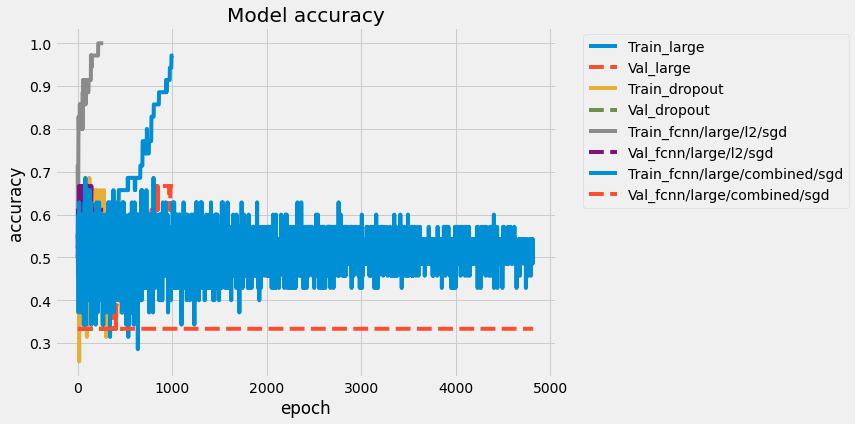

In [40]:
plot_report(regularizer_histories, 'accuracy')

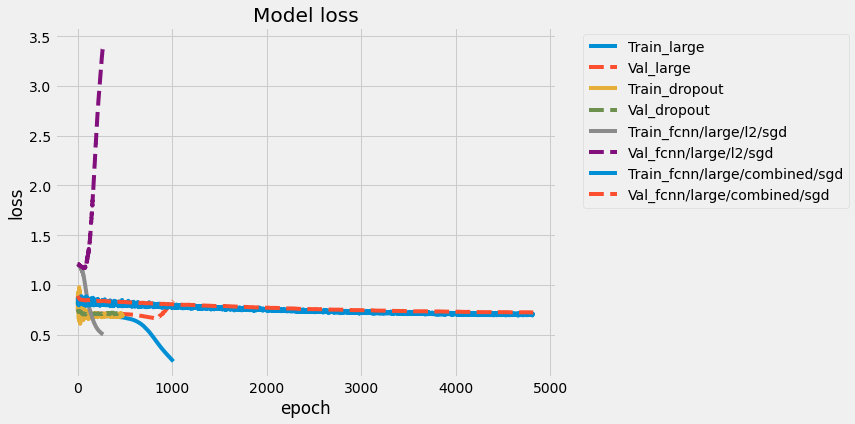

In [41]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [42]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large/sgd']
batch_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

In [43]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(inputs)
norm_1 = tf.keras.layers.BatchNormalization()(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(norm_1)
norm_2 = tf.keras.layers.BatchNormalization()(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(norm_2)
norm_3 = tf.keras.layers.BatchNormalization()(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(norm_3)
norm_4 = tf.keras.layers.BatchNormalization()(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(norm_4)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

batch_histories['fcnn/small/batch/sgd'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 16)                65552     
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64    

Epoch 46/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3814 - accuracy: 0.9714 - val_loss: 1.4165 - val_accuracy: 0.3889
Epoch 47/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3753 - accuracy: 1.0000 - val_loss: 1.5009 - val_accuracy: 0.3889
Epoch 48/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3751 - accuracy: 1.0000 - val_loss: 1.4648 - val_accuracy: 0.3889
Epoch 49/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.9429 - val_loss: 1.5004 - val_accuracy: 0.3889
Epoch 50/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3700 - accuracy: 0.9714 - val_loss: 1.5636 - val_accuracy: 0.3889
Epoch 51/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.3683 - accuracy: 1.0000 - val_loss: 1.5353 - val_accuracy: 0.3889
Epoch 52/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.3630 - accuracy: 1.0000 - val_loss: 1.6802 - val_accuracy: 0.3889
Epoch 53/5000

9/9 [==============================] - 0s 3ms/step - loss: 0.2815 - accuracy: 1.0000 - val_loss: 2.4794 - val_accuracy: 0.5000
Epoch 105/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2812 - accuracy: 1.0000 - val_loss: 2.5221 - val_accuracy: 0.5000
Epoch 106/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2808 - accuracy: 1.0000 - val_loss: 2.4411 - val_accuracy: 0.5556
Epoch 107/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2791 - accuracy: 1.0000 - val_loss: 2.5357 - val_accuracy: 0.5000
Epoch 108/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2786 - accuracy: 1.0000 - val_loss: 2.4728 - val_accuracy: 0.5556
Epoch 109/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 1.0000 - val_loss: 2.6266 - val_accuracy: 0.5000
Epoch 110/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2783 - accuracy: 1.0000 - val_loss: 2.4256 - val_accuracy: 0.5556
Epoch 111/5000
9/9 [=

Epoch 162/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2669 - accuracy: 1.0000 - val_loss: 1.5763 - val_accuracy: 0.3889
Epoch 163/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2665 - accuracy: 1.0000 - val_loss: 1.5795 - val_accuracy: 0.3889
Epoch 164/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2649 - accuracy: 1.0000 - val_loss: 1.5999 - val_accuracy: 0.3889
Epoch 165/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2642 - accuracy: 1.0000 - val_loss: 1.5995 - val_accuracy: 0.3889
Epoch 166/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2634 - accuracy: 1.0000 - val_loss: 1.6151 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 0s 4ms/step - loss: 0.2614 - accuracy: 1.0000 - val_loss: 1.6066 - val_accuracy: 0.3889
Epoch 168/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.2613 - accuracy: 1.0000 - val_loss: 1.6230 - val_accuracy: 0.5000
Epoch 

In [60]:
batch_histories['fcnn/small/batch/sgd'].history['accuracy'][-1], batch_histories['fcnn/small/batch/sgd'].history['val_accuracy'][-1]

(1.0, 0.4444444477558136)

In [45]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 1.1127 - accuracy: 0.7714
training loss : 1.1127461194992065
training accuracy : 0.7714285850524902
5/5 [==============================] - 0s 2ms/step - loss: 2.0466 - accuracy: 0.4444
test loss : 2.046588182449341
test accuracy : 0.4444444477558136


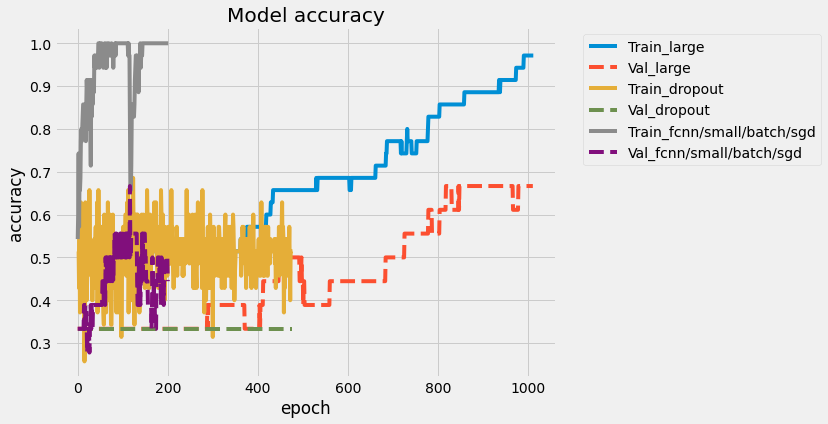

In [46]:
plot_report(batch_histories, 'accuracy')

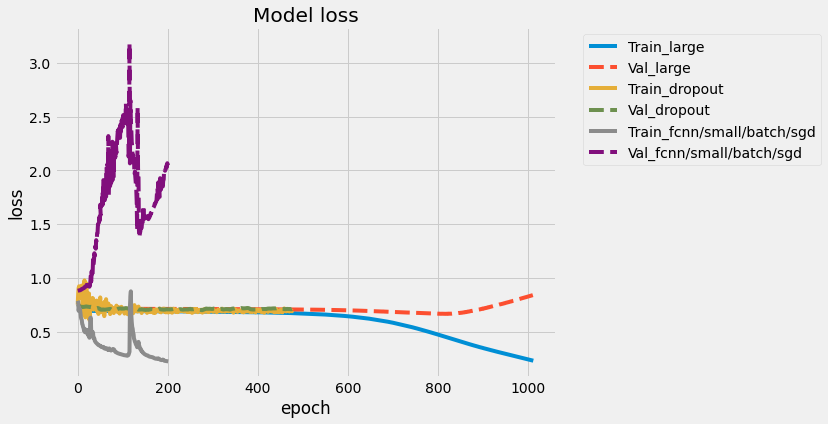

In [47]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [48]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large/sgd']
lstm_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

In [49]:
lambda_1 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)# expand the dimension form (50, 4096) to (50, 4096, 1)
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lambda_1)
dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_1)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/tiny'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 lambda (Lambda)             (None, 4096, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
9/9 [==============================] - 3s 14

Epoch 51/5000
9/9 [==============================] - 1s 111ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 52/5000
9/9 [==============================] - 1s 112ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 53/5000
9/9 [==============================] - 1s 114ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 54/5000
9/9 [==============================] - 1s 112ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 55/5000
9/9 [==============================] - 1s 121ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 56/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 57/5000
9/9 [==============================] - 1s 112ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333

9/9 [==============================] - 1s 113ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 109/5000
9/9 [==============================] - 1s 114ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 110/5000
9/9 [==============================] - 1s 115ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 111/5000
9/9 [==============================] - 1s 121ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 112/5000
9/9 [==============================] - 1s 111ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 113/5000
9/9 [==============================] - 1s 112ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 114/5000
9/9 [==============================] - 1s 112ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 1

Epoch 165/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 166/5000
9/9 [==============================] - 1s 114ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 1s 116ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 168/5000
9/9 [==============================] - 1s 115ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 169/5000
9/9 [==============================] - 1s 114ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 170/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 171/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy:

Epoch 222/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 223/5000
9/9 [==============================] - 1s 120ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 224/5000
9/9 [==============================] - 1s 120ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 225/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 226/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 227/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 228/5000
9/9 [==============================] - 1s 113ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy:

Epoch 279/5000
9/9 [==============================] - 1s 114ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 280/5000
9/9 [==============================] - 1s 117ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 281/5000
9/9 [==============================] - 1s 116ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 282/5000
9/9 [==============================] - 1s 115ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 283/5000
9/9 [==============================] - 1s 115ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 284/5000
9/9 [==============================] - 1s 119ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 285/5000
9/9 [==============================] - 1s 121ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy:

In [50]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 47ms/step - loss: 0.7002 - accuracy: 0.5143
training loss : 0.700223982334137
training accuracy : 0.5142857432365417
5/5 [==============================] - 0s 45ms/step - loss: 0.7200 - accuracy: 0.3333
test loss : 0.7200013995170593
test accuracy : 0.3333333432674408


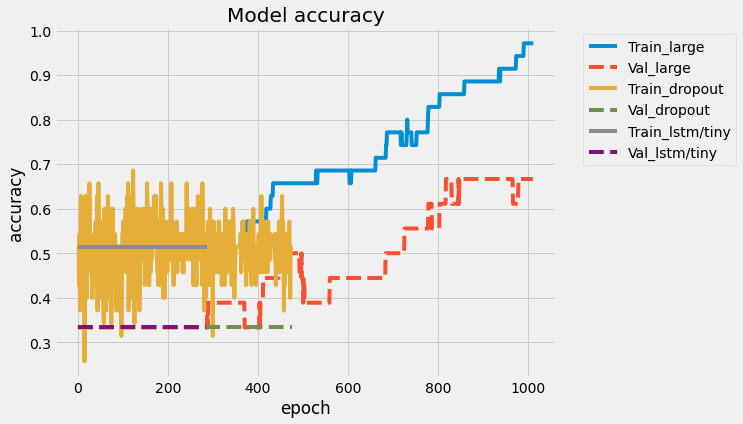

In [51]:
plot_report(lstm_histories, 'accuracy')

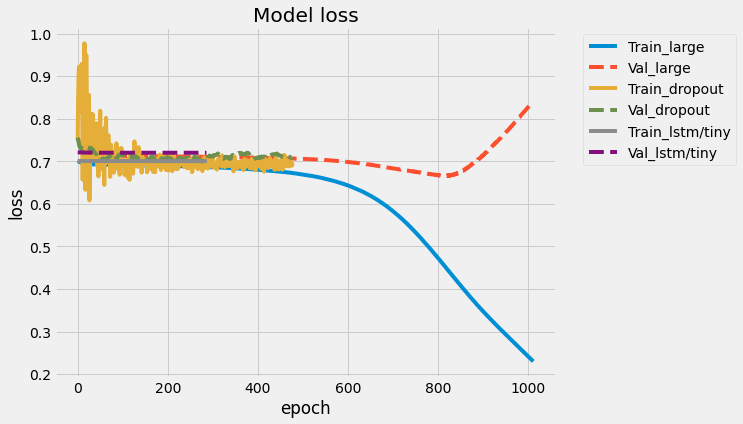

In [52]:
plot_report(lstm_histories, 'loss')

In [53]:
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lambda_1)
lstm_2 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lstm_1)

dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_2)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/small'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 lambda (Lambda)             (None, 4096, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 4096, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 50,449
Trainable params: 50,449
Non-trainable p

Epoch 50/5000
9/9 [==============================] - 2s 218ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7158 - val_accuracy: 0.3333
Epoch 51/5000
9/9 [==============================] - 2s 213ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7160 - val_accuracy: 0.3333
Epoch 52/5000
9/9 [==============================] - 2s 216ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7163 - val_accuracy: 0.3333
Epoch 53/5000
9/9 [==============================] - 2s 216ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7166 - val_accuracy: 0.3333
Epoch 54/5000
9/9 [==============================] - 2s 214ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7168 - val_accuracy: 0.3333
Epoch 55/5000
9/9 [==============================] - 2s 214ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7170 - val_accuracy: 0.3333
Epoch 56/5000
9/9 [==============================] - 2s 215ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7172 - val_accuracy: 0.3333

9/9 [==============================] - 2s 218ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 108/5000
9/9 [==============================] - 2s 219ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 109/5000
9/9 [==============================] - 2s 217ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 110/5000
9/9 [==============================] - 2s 222ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7200 - val_accuracy: 0.3333
Epoch 111/5000
9/9 [==============================] - 2s 225ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 112/5000
9/9 [==============================] - 2s 214ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 113/5000
9/9 [==============================] - 2s 214ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 1

Epoch 164/5000
9/9 [==============================] - 2s 213ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 165/5000
9/9 [==============================] - 2s 216ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 166/5000
9/9 [==============================] - 2s 217ms/step - loss: 0.7006 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 2s 215ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 168/5000
9/9 [==============================] - 2s 218ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 169/5000
9/9 [==============================] - 2s 218ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy: 0.3333
Epoch 170/5000
9/9 [==============================] - 2s 215ms/step - loss: 0.7005 - accuracy: 0.5143 - val_loss: 0.7201 - val_accuracy:

In [54]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 1s 90ms/step - loss: 0.7004 - accuracy: 0.5143
training loss : 0.700360894203186
training accuracy : 0.5142857432365417
5/5 [==============================] - 0s 91ms/step - loss: 0.7201 - accuracy: 0.3333
test loss : 0.7201052904129028
test accuracy : 0.3333333432674408


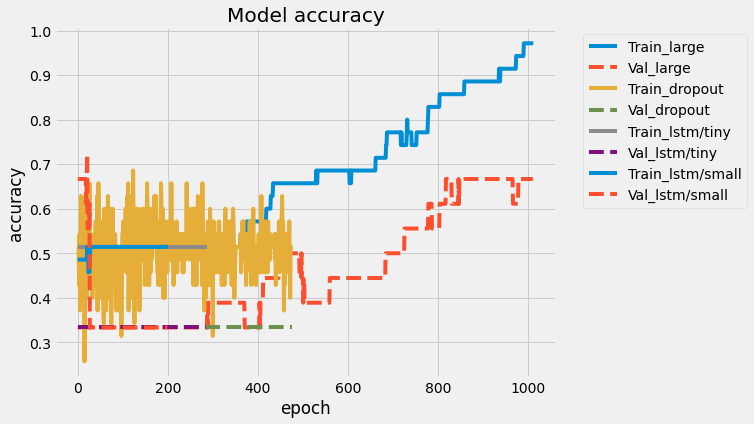

In [55]:
plot_report(lstm_histories, 'accuracy')

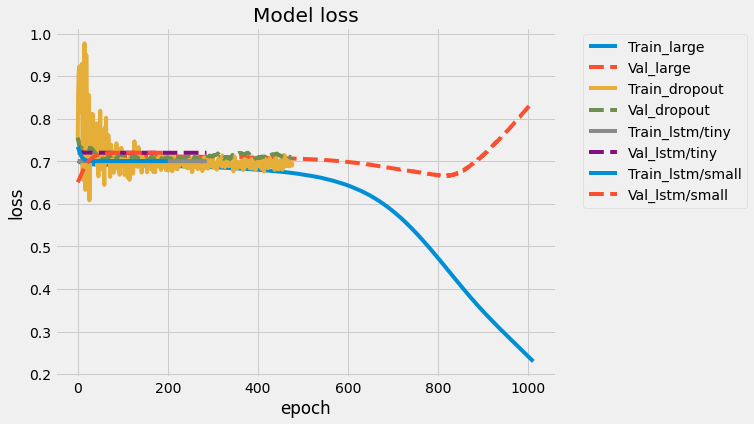

In [56]:
plot_report(lstm_histories, 'loss')

In [57]:
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lambda_1)
lstm_2 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lstm_2)

dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/large'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 lambda (Lambda)             (None, 4096, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 4096, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, 4096, 64)          33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9     

Epoch 49/5000
9/9 [==============================] - 3s 321ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7195 - val_accuracy: 0.3333
Epoch 50/5000
9/9 [==============================] - 3s 319ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7196 - val_accuracy: 0.3333
Epoch 51/5000
9/9 [==============================] - 3s 318ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7196 - val_accuracy: 0.3333
Epoch 52/5000
9/9 [==============================] - 3s 318ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7197 - val_accuracy: 0.3333
Epoch 53/5000
9/9 [==============================] - 3s 319ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7197 - val_accuracy: 0.3333
Epoch 54/5000
9/9 [==============================] - 3s 320ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7197 - val_accuracy: 0.3333
Epoch 55/5000
9/9 [==============================] - 3s 320ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7198 - val_accuracy: 0.3333

9/9 [==============================] - 3s 321ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 107/5000
9/9 [==============================] - 3s 320ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 108/5000
9/9 [==============================] - 3s 320ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 109/5000
9/9 [==============================] - 3s 321ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 110/5000
9/9 [==============================] - 3s 319ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 111/5000
9/9 [==============================] - 3s 319ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 112/5000
9/9 [==============================] - 3s 321ms/step - loss: 0.7004 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 1

Epoch 163/5000
9/9 [==============================] - 3s 319ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 164/5000
9/9 [==============================] - 3s 324ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 165/5000
9/9 [==============================] - 3s 320ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 166/5000
9/9 [==============================] - 3s 323ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 167/5000
9/9 [==============================] - 3s 323ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 168/5000
9/9 [==============================] - 3s 321ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy: 0.3333
Epoch 169/5000
9/9 [==============================] - 3s 321ms/step - loss: 0.7003 - accuracy: 0.5143 - val_loss: 0.7202 - val_accuracy:

In [61]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 1s 134ms/step - loss: 0.7002 - accuracy: 0.5143
training loss : 0.7001570463180542
training accuracy : 0.5142857432365417
5/5 [==============================] - 1s 132ms/step - loss: 0.7201 - accuracy: 0.3333
test loss : 0.7201433181762695
test accuracy : 0.3333333432674408


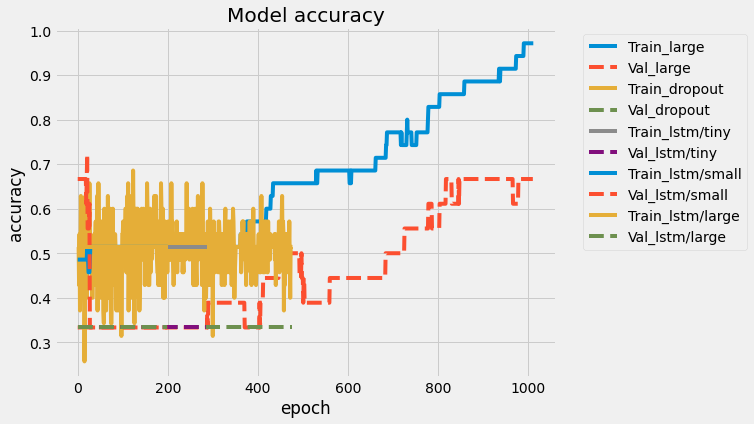

In [58]:
plot_report(lstm_histories, 'accuracy')

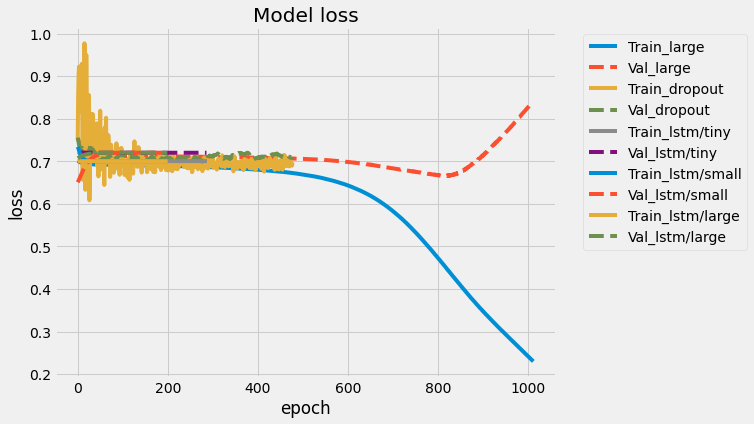

In [59]:
plot_report(lstm_histories, 'loss')